In [1]:
import warnings

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import matplotlib.colors as mcolors
#import matplotlib.colors

import math as math

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.ticker as mticker
import pandas as pd
from matplotlib import gridspec

import numpy.ma as ma

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

Read in the model data files

In [2]:
datadir='/shared/CAREER_PWC/DeepMIP-EOT/um_grid/monthly/'
ldir=['ocean','surface']
mdir=['baatsen','huber','hutchinson','kennedy','ladant','zhang']

In [3]:
mons=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

Compile sea surface model temperature files into an array

In [4]:
filename=[]
for i in range(len(mdir)):
    m=datadir+ldir[0]+'/'+mdir[i]+'/'+'*'
    files=!ls {m}
    for j in range(len(files)):
        if i==0 and j==0:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            ds['time']=mons
            SST=ds.temp
            SST.expand_dims(dim='exp')
            filename.append(files[j])
        elif i==2:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            ds['time']=mons
            if i==2 and j==0:
                continue
            SST=xr.concat([SST,ds.sst], dim='exp')
            filename.append(files[j])
        elif i==3:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            ds['time']=mons
            SST=xr.concat([SST, ds.sst], 'exp')
            filename.append(files[j])
        elif i==4:
            ds=xr.open_dataset(files[j],engine="netcdf4",decode_times=False)
            ds['time']=mons
            r=ds.where(ds['TEMP'] < 9999.) 
            if i==4 and j==0 or j==2 or j==3:
                continue
            SST=xr.concat([SST, r.TEMP], 'exp')
            filename.append(files[j])
        elif i==5:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            ds['time']=mons
            if i==5 and j==0:
                continue
            SST=xr.concat([SST, ds.templvl], 'exp')
            filename.append(files[j])
        else:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            ds['time']=mons
            if i==1 and j==3:
                continue
            if i==1:
                ds2=ds.rename_dims({'lat':'latitude','lon':'longitude'})
                ds['time']=mons
                SST=xr.concat([SST, ds2.temp], dim='exp')
                filename.append(files[j])
            else:
                ds['time']=mons
                SST=xr.concat([SST, ds.temp], dim='exp')
                filename.append(files[j])
            

Compile surface air model temperature files into an array

In [5]:
#Surface Air temperature
filename_SAT=[]
for i in range(len(mdir)):
    m=datadir+ldir[1]+'/'+mdir[i]+'/'+'*'
    files=!ls {m}
    for j in range(len(files)):
        if i==0 and j==0:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            ds['time']=mons
            ds['TREFHT']=ds['TREFHT']-273.15
            SAT=ds.TREFHT
            filename_SAT.append(files[j])
        elif i==2:        
            ds=xr.open_dataset(files[j],engine="netcdf4")
            ds['time']=mons
            ds['t_ref']=ds['t_ref']-273.15
            if i==2 and j==0:
                continue
            SAT=xr.concat([SAT,ds.t_ref], dim='exp')
            filename_SAT.append(files[j])
        elif i==3:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            ds['time']=mons
            ds['temp']=ds['temp']-273.15
            if i==3 and j==5 or j==7:
                continue
            SAT=xr.concat([SAT, ds.temp], 'exp')
            filename_SAT.append(files[j])
        elif i==4:
            ds=xr.open_dataset(files[j],engine="netcdf4",decode_times=False)
            ds['time']=mons
            ds['TEMP']=ds['TEMP']-273.15
            if i==4 and j==1 or j==2 or j==3:
                continue
            SAT=xr.concat([SAT, ds.TEMP], 'exp')
            filename_SAT.append(files[j])
        elif i==5:
            ds=xr.open_dataset(files[j],engine="netcdf4",decode_times=False)
            ds['time']=mons
            ds['TS']=ds['TS']-273.15
            if i==5 and j==0:
                continue
            SAT=xr.concat([SAT, ds.TS], 'exp')
            filename_SAT.append(files[j])            
        else:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            ds['time']=mons
            ds['TREFHT']=ds['TREFHT']-273.15
            if i==1 and j==3:
                continue
            if ds.TREFHT.dims[0]=='lat' and ds.TREFHT.dims[1]=='lon':
                ds2=ds.rename_dims({'lat':'latitude','lon':'longitude'})
                SAT=xr.concat([SAT, ds2.TREFHT], dim='exp')
                filename_SAT.append(files[j])
            else:
                SAT=xr.concat([SAT, ds.TREFHT], dim='exp')
                filename_SAT.append(files[j])

In [6]:
SST_updated=SST.sortby('latitude',ascending=True)
SAT_updated=SAT.sortby('latitude',ascending=True)

Isolate only summer versus winter month files

In [7]:
summer=SST_updated[:,[-1,0,1],:,:]
winter=SST_updated[:,5:8,:,:]

summer_SAT=SAT_updated[:,[-1,0,1],:,:]
winter_SAT=SAT_updated[:,5:8,:,:]

In [8]:
#Calculate the average summer and winter temperatures for each model
summer_avg=np.mean(summer, axis=1)
winter_avg=np.mean(winter, axis=1)
summer_avg_SAT=np.mean(summer_SAT, axis=1)
winter_avg_SAT=np.mean(winter_SAT, axis=1)

In [9]:
seasonalitydiff=summer_avg-winter_avg
seasonalitydiff_SAT=summer_avg_SAT-winter_avg_SAT

seasonalityAA=seasonalitydiff_SAT.where(seasonalitydiff.latitude<-40)
seasonality_AA=seasonalityAA.dropna(dim='latitude',how='all')

Adding identifiers for each file to filter for comparisons

In [10]:
CO2_concx=np.array([560,1120,560,560,1120,1120,1120,400,800,800,560,560,560,1120,560,560,560,560,1120,560,980,560])
CO2_concx_SST=np.array(['2x','4x','','2x','','4x','','2x','4x','','','2x','','4x','','','','2x','4x','','4x','2x'])
CO2_concx_SAT=np.array(['2x','4x','','2x','','4x','','2x','4x','','','2x','','4x','','','2x','','4x','','4x','2x'])

In [11]:
#identification of each file parameter to call for plotting. SST and SAT need separate calls due to a difference file order for Ladant 
modelnames=np.array(['CESM_B','CESM_B','CESM_H','CESM_H','CESM_H','CESM_H','CESM_H','GFDL_CM2.1','GFDL_CM2.1','GFDL_CM2.1','HadCM3BL','HadCM3BL','HadCM3BL','HadCM3BL','HadCM3BL','FOAM','FOAM','FOAM','FOAM','NorESM-L','NorESM-L','NorESM-L'])
run_infoice_SST=np.array(['','','ice','No ice','','','','','','','ice','No ice','','','','','ice','No ice','','','',''])
run_infogeo_SST=np.array(['','','','','PreEOT','','PostEOT','','PreEOT','PostEOT','','','PostEOT','','PreEOT','PostEOT','','PreEOT','','PostEOT','','PreEOT'])

run_infoice_SAT=np.array(['','','ice','No ice','','','','','','','ice','No ice','','','','','No ice','ice','','',''])
run_infogeo_SAT=np.array(['','','','','PreEOT','','PostEOT','','PreEOT','PostEOT','','','PostEOT','','PreEOT','PostEOT','PreEOT','','','PreEOT','PostEOT'])

In [12]:
#isolating only 2x runs
CO2_concx2_SST=np.where(CO2_concx_SST=='2x')
CO2_concls_2x_SST=np.array(CO2_concx2_SST)
SST_conc2x=seasonalitydiff[CO2_concls_2x_SST[0,:],:,:]
landmask_2x=np.isnan(SST_conc2x)

CO2_concx2_SAT=np.where(CO2_concx_SAT=='2x')
CO2_concls_2x_SAT=np.array(CO2_concx2_SAT)
SAT_conc2x=seasonalitydiff_SAT[CO2_concls_2x_SAT[0,:],:,:]

model_SAT=modelnames[CO2_concls_2x_SAT[0,:]]

model_high=modelnames[CO2_concls_2x_SST[0,:]]
conc_2x=CO2_concx[CO2_concls_2x_SST[0,:]]

#isolating only 4x runs
CO2_concx4_SST=np.where(CO2_concx_SST=='4x')
CO2_concls_4x_SST=np.array(CO2_concx4_SST)
SST_conc4x=seasonalitydiff[CO2_concls_4x_SST[0,:],:,:]
landmask_4x=np.isnan(SST_conc4x)

CO2_concx4_SAT=np.where(CO2_concx_SAT=='4x')
CO2_concls_4x_SAT=np.array(CO2_concx4_SAT)
SAT_conc4x=seasonalitydiff_SAT[CO2_concls_4x_SAT[0,:],:,:]

model_high=modelnames[CO2_concls_4x_SST[0,:]]
conc_high=CO2_concx[CO2_concls_4x_SST[0,:]]

#difference plots for CO2 temperature between 2x and 4x
SST_diffconcx=SST_conc2x-SST_conc4x

SAT_diffconcx=SAT_conc2x-SAT_conc4x

Calculate and add the model ensemble mean

In [13]:
#model ensemble mean
ensemblemean_SST=np.mean(SST_diffconcx,axis=0)
diff_modelconc_SST=xr.concat([SST_diffconcx,ensemblemean_SST],'exp')
ensemblemean_SAT=np.mean(SAT_diffconcx,axis=0)
diff_modelconc_SAT=xr.concat([SAT_diffconcx,ensemblemean_SAT],'exp')

landmaskmean=np.mean(landmask_2x)
landmask=xr.concat([landmask_2x,landmaskmean],'exp')

#Eocene mean
ensemblemean_eo_SST=np.mean(SST_conc4x, axis=0)
SSTmodel_EO=xr.concat([SST_conc4x,ensemblemean_eo_SST],'exp')
ensemblemean_eo_SAT=np.mean(SAT_conc4x, axis=0)
SATmodel_EO=xr.concat([SAT_conc4x,ensemblemean_eo_SAT],'exp')
landmask_4xmean=np.mean(landmask_4x)
landmask_4x=xr.concat([landmask_4x,landmask_4xmean],'exp')

#Oligocene mean
ensemblemean_oligo_SST=np.mean(SST_conc2x, axis=0)
SSTmodel_Oligo=xr.concat([SST_conc2x,ensemblemean_oligo_SST],'exp')
ensemblemean_oligo_SAT=np.mean(SAT_conc2x, axis=0)
SATmodel_Oligo=xr.concat([SAT_conc2x,ensemblemean_oligo_SAT],'exp')

Read in the proxy temperature anomalies both SST and SAT

In [14]:
EOT_proxy_SST=pd.read_csv('/homes/etibbett/EOT_data_share/EOT_temperaturecomparison_python_10.5.csv',header=0,usecols=['Paleolatitude','Paleolongitude','Oligo SST','Eocene SST'])
EOT_proxy_SAT=pd.read_csv('/homes/etibbett/EOT_data_share/EOT_temperaturecomparison_python_10.5.csv',header=0,usecols=['Paleolatitude','Paleolongitude','Oligo SAT','Eocene SAT'])


EOT_proxydiff_SST=EOT_proxy_SST['Oligo SST']-EOT_proxy_SST['Eocene SST']
EOT_proxydiff_SAT=EOT_proxy_SAT['Oligo SAT']-EOT_proxy_SAT['Eocene SAT']

proxydiff_SST=EOT_proxydiff_SST.dropna()
SST_proxydiff=proxydiff_SST.to_xarray()
proxydiff_SAT=EOT_proxydiff_SAT.dropna()
SAT_proxydiff=proxydiff_SAT.to_xarray()

SAT_proxy=EOT_proxy_SAT.dropna()
proxy_SAT=SAT_proxy.to_xarray()

SST_proxy=EOT_proxy_SST.dropna()
proxy_SST=SST_proxy.to_xarray()

EOT_proxy_SAT['EOT diff']=EOT_proxy_SAT['Oligo SAT']-EOT_proxy_SAT['Eocene SAT']
EOT_proxy_SST['EOT diff']=EOT_proxy_SST['Oligo SST']-EOT_proxy_SST['Eocene SST']


In [15]:
EOT_proxy_SST = EOT_proxy_SST.drop(labels=9, axis=0)
EOT_proxy_SST = EOT_proxy_SST.drop(labels=12, axis=0)

EOT_proxy_SST=EOT_proxy_SST.reset_index()

In [16]:
EOT_proxy_SST['New paleolat']=EOT_proxy_SST['Paleolatitude']
EOT_proxy_SST['New paleolon']=EOT_proxy_SST['Paleolongitude']

In [17]:
proxy_seasonality=EOT_proxy_SST[8:10]
proxy_seasonality=proxy_seasonality.reset_index()
proxy_seasonality['New paleolon'][0]=315

/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
#making a colormap without the white
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

seismic = cm.get_cmap('seismic', 20)
seismic_colors=seismic(np.linspace(0, 1, 20))
colors = seismic_colors  # R -> G -> B
cmap_name = 'seismic_nowhite'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=20)

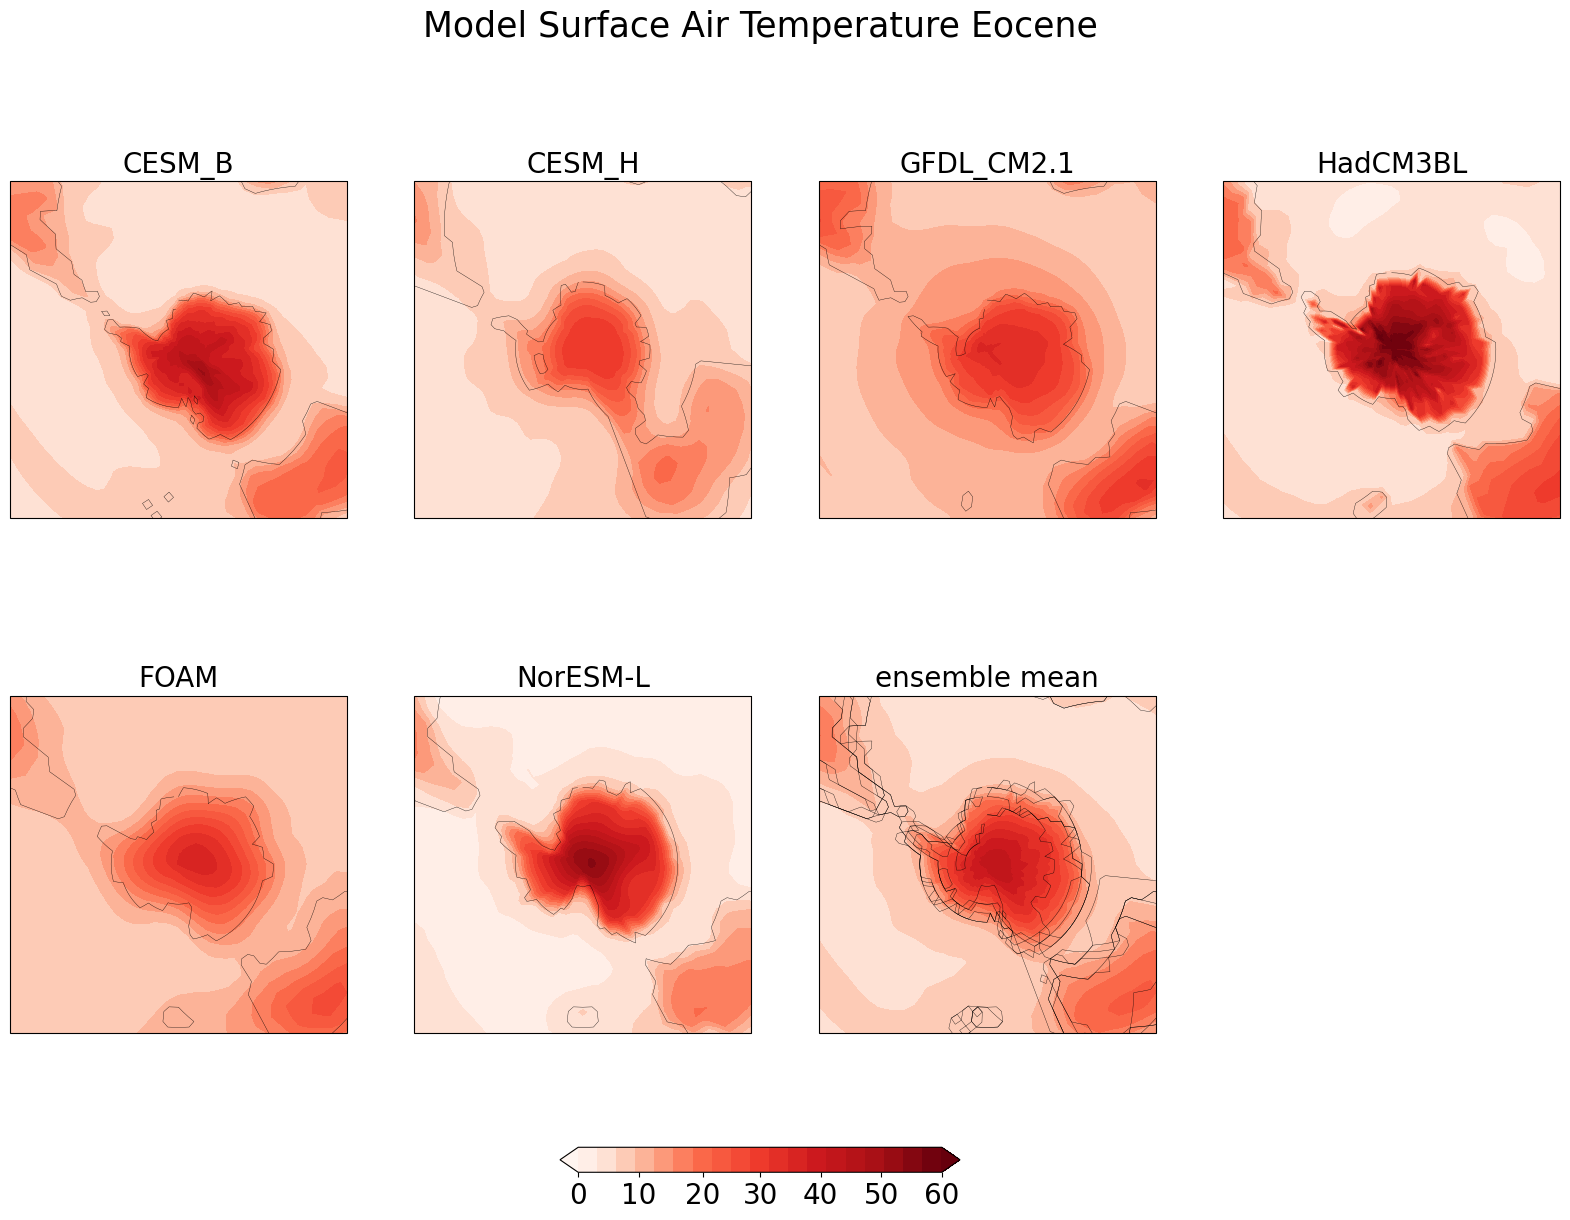

In [19]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=0,vcenter=20,vmax=60)

for j in range(0,len(SATmodel_EO)):
    var = SATmodel_EO[j][lats,lons]

# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=SATmodel_EO.longitude)
    
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap='Reds',norm=norm,levels=np.linspace(0,60,20),extend='both')
    coast=landmask[j,:,:]*1
    if j==6:
        for k in range(0,6):
            coast_all=landmask[k,:,:]*1
            ax.contour(landmask.longitude,landmask.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title("ensemble mean", fontsize=20)
    else:
        ax.contour(landmask.longitude,landmask.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        ax.set_title(model_high[j], fontsize=20)
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
       
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[0,10,20,30,40,50,60])
cb.ax.tick_params(labelsize=20)
plt.suptitle('Model Surface Air Temperature Eocene',fontsize=25)
plt.savefig('SAT_Eoceneseasonality.pdf')

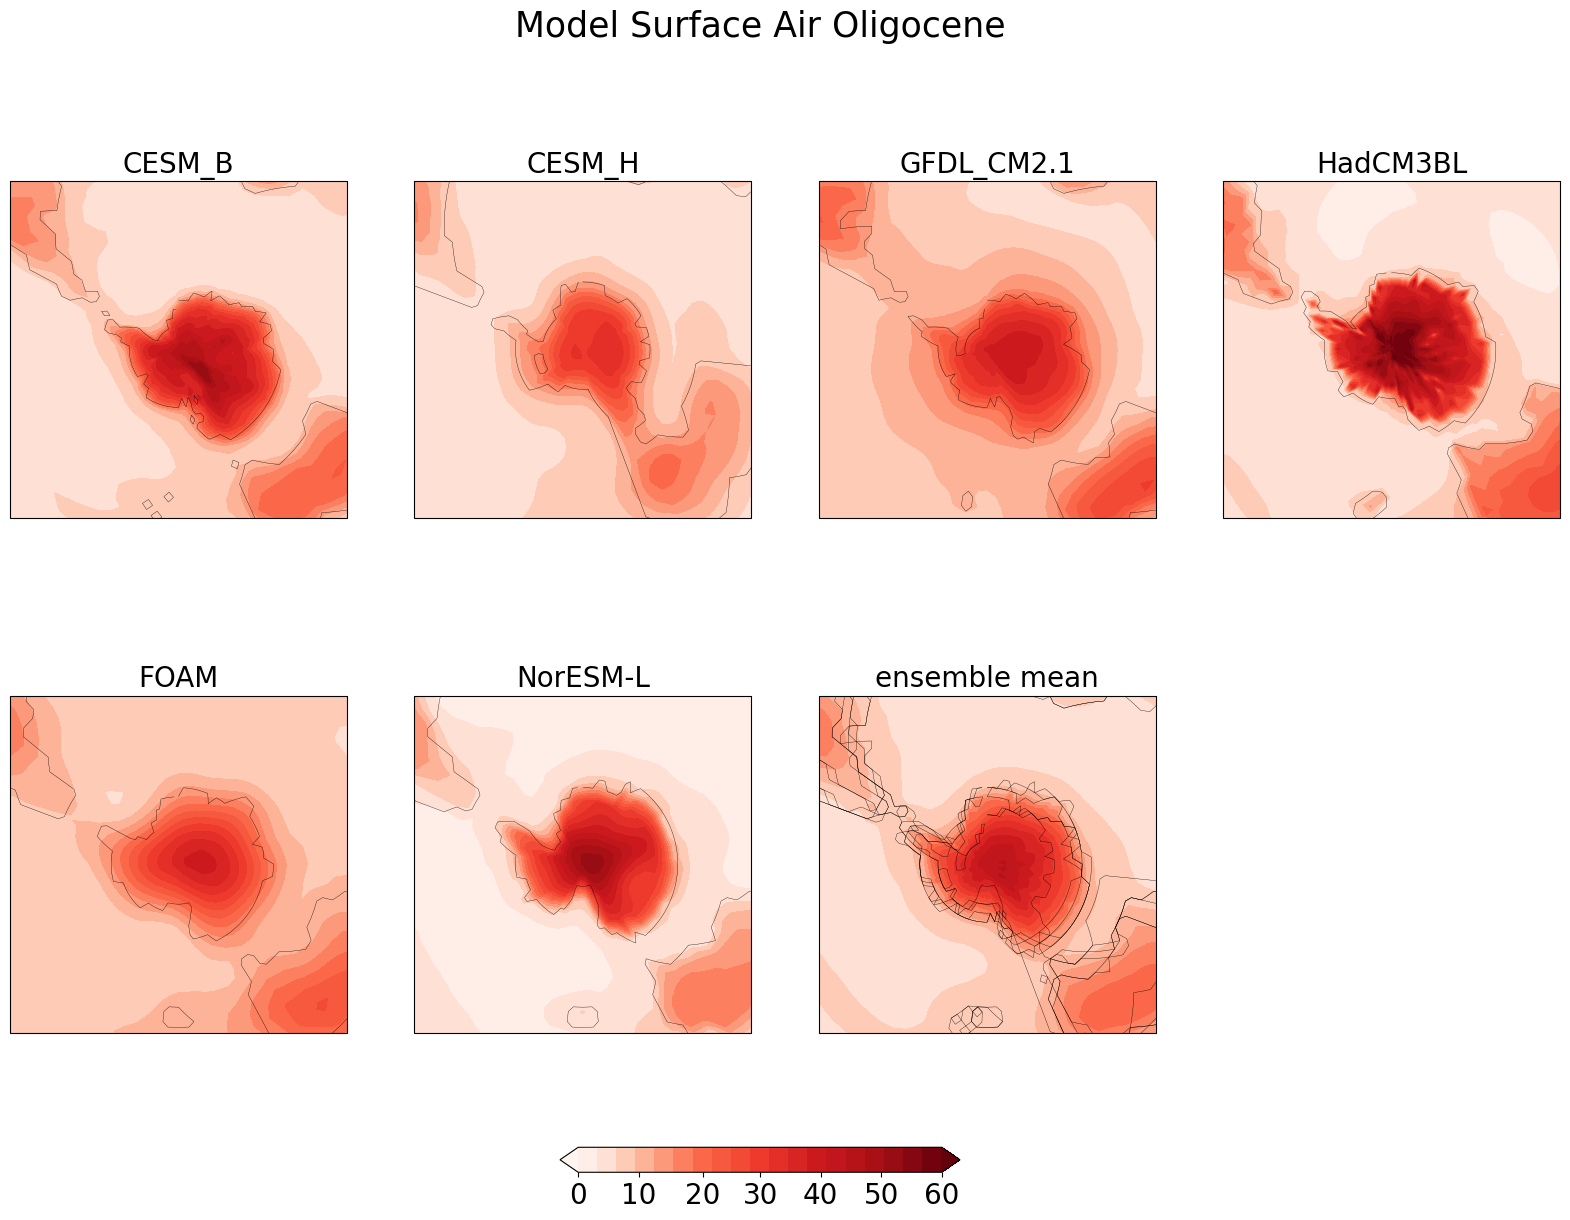

In [20]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=0,vcenter=20,vmax=60)

for j in range(0,len(SATmodel_Oligo)):
    var = SATmodel_Oligo[j][lats,lons]

# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=SATmodel_Oligo.longitude)
    
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap='Reds',norm=norm,levels=np.linspace(0,60,20),extend='both')
    coast=landmask[j,:,:]*1
    if j==6:
        for k in range(0,6):
            coast_all=landmask[k,:,:]*1
            ax.contour(landmask.longitude,landmask.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title("ensemble mean", fontsize=20)
    else:
        ax.contour(landmask.longitude,landmask.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        ax.set_title(model_high[j], fontsize=20)
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
       
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[0,10,20,30,40,50,60])
cb.ax.tick_params(labelsize=20)
plt.suptitle('Model Surface Air Oligocene',fontsize=25)
plt.savefig('SAT_seasonalityOligo.pdf')

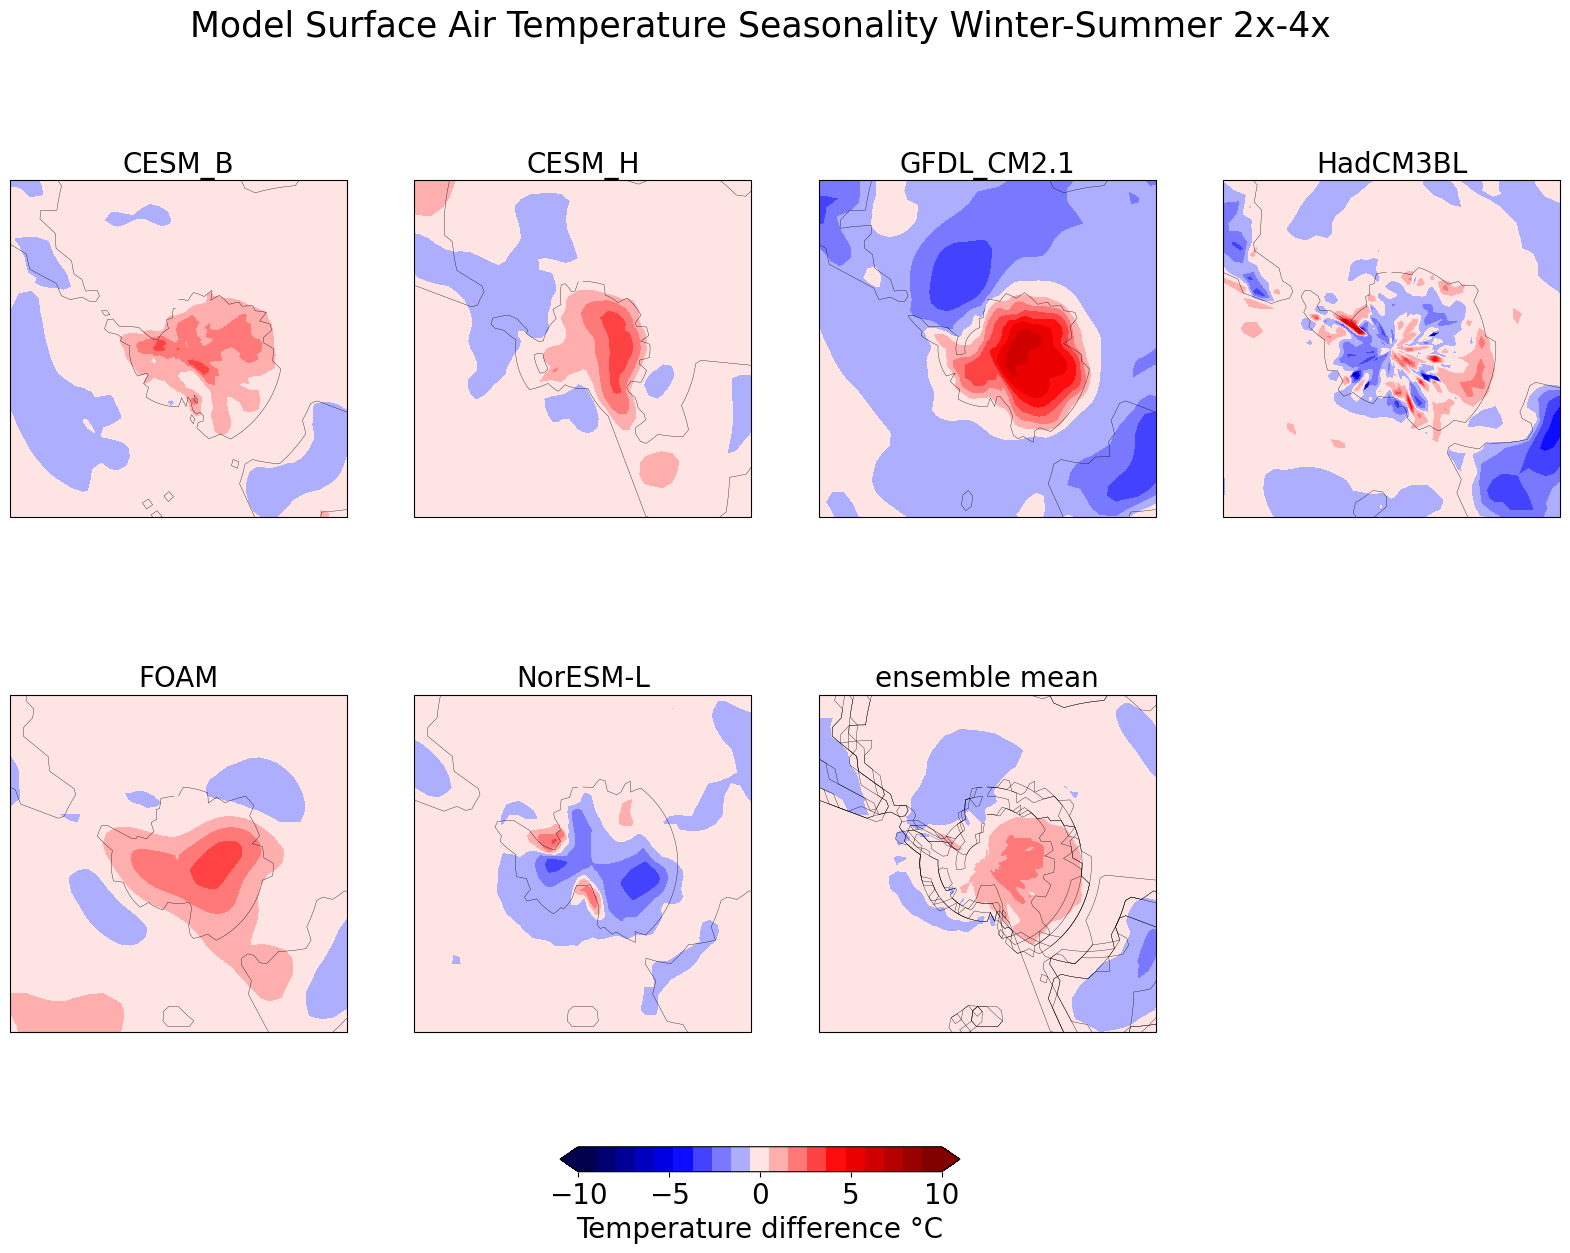

In [21]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=10)

for j in range(0,len(diff_modelconc_SAT)):
    var = diff_modelconc_SAT[j][lats,lons]
    
# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=diff_modelconc_SAT.longitude)

# Make a filled contour plot
    
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,10,20),extend='both')
    coast=landmask[j,:,:]*1
    if j==6:
        for k in range(0,6):
            coast_all=landmask[k,:,:]*1
            ax.contour(landmask.longitude,landmask.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title("ensemble mean", fontsize=20)
    else:
        ax.contour(landmask.longitude,landmask.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        ax.set_title(model_SAT[j], fontsize=20)
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())

colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5,10,15])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Surface Air Temperature Seasonality Winter-Summer 2x-4x',fontsize=25)
plt.savefig('SAT_seasonalityEOT.pdf')

Months above Freezing

In [22]:
#calculate months above freeing
AF=SAT_updated.where(SAT_updated > 0) 
MAF=AF.mean(dim='time',skipna=True)

In [23]:
#isolating only 2x runs
CO2_concx2_SAT=np.where(CO2_concx_SAT=='2x')
CO2_concls_2x_SAT=np.array(CO2_concx2_SAT)
SAT_conc2x=MAF[CO2_concls_2x_SAT[0,:],:,:]

#isolating only 4x runs
CO2_concx4_SAT=np.where(CO2_concx_SAT=='4x')
CO2_concls_4x_SAT=np.array(CO2_concx4_SAT)
SAT_conc4x=MAF[CO2_concls_4x_SAT[0,:],:,:]

SAT_diffconcx=SAT_conc2x-SAT_conc4x

In [24]:
#model ensemble mean
ensemblemean_SAT=np.mean(SAT_diffconcx,axis=0)
diff_modelconc_SAT=xr.concat([SAT_diffconcx,ensemblemean_SAT],'exp')

#Eocene mean

ensemblemean_eo_SAT=np.mean(SAT_conc4x, axis=0)
SATmodel_EO=xr.concat([SAT_conc4x,ensemblemean_eo_SAT],'exp')
#Oligocene mean

ensemblemean_oligo_SAT=np.mean(SAT_conc2x, axis=0)
SATmodel_Oligo=xr.concat([SAT_conc2x,ensemblemean_oligo_SAT],'exp')

Eocene

In [25]:
Eocene_proxy_SAT = EOT_proxy_SAT[EOT_proxy_SAT['Eocene SAT'].notnull()].reset_index(drop=True)

In [26]:
#create separate datafiles for each model for the proxy input to adjust paleocoordinates and model averaging
Eocene_proxy_SAT0=Eocene_proxy_SAT[:]
Eocene_proxy_SAT1=Eocene_proxy_SAT[:]
Eocene_proxy_SAT2=Eocene_proxy_SAT[:]
Eocene_proxy_SAT3=Eocene_proxy_SAT[:]
Eocene_proxy_SAT4=Eocene_proxy_SAT[:]
Eocene_proxy_SAT5=Eocene_proxy_SAT[:]
Eocene_proxy_SAT6=Eocene_proxy_SAT[:]

In [27]:
#1st model
Eocene_proxy_SAT0['New paleolat']=Eocene_proxy_SAT0['Paleolatitude']
Eocene_proxy_SAT0['New paleolon']=Eocene_proxy_SAT0['Paleolongitude']

latchange=[-7,-7,0,5,-5,-7,-7,0,-7,-7,-5,-6,-3]
lonchange=[5,5,-4,0,-8,-5,-5,-7,-6,5,-10,-15,-12]
for i in range(0,13):
        Eocene_proxy_SAT0['New paleolat'][i]=Eocene_proxy_SAT0['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT0['New paleolon'][i]=Eocene_proxy_SAT0['Paleolongitude'][i]+lonchange[i]

#2nd model
Eocene_proxy_SAT1['New paleolat']=Eocene_proxy_SAT1['Paleolatitude']
Eocene_proxy_SAT1['New paleolon']=Eocene_proxy_SAT1['Paleolongitude']


latchange=[-12,-12,0,0,-1,-3,-3,0,-3,-12,-1,-2,-8]
lonchange=[0,0,-4,5,-9,-6,-6,-7,-7,0,-10,-16,-7]
for i in range(0,13):
        Eocene_proxy_SAT1['New paleolat'][i]=Eocene_proxy_SAT1['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT1['New paleolon'][i]=Eocene_proxy_SAT1['Paleolongitude'][i]+lonchange[i]
        
#3rd model        
Eocene_proxy_SAT2['New paleolat']=Eocene_proxy_SAT2['Paleolatitude']
Eocene_proxy_SAT2['New paleolon']=Eocene_proxy_SAT2['Paleolongitude']

latchange=[-8,-8,0,5,-5,-7,-7,0,-7,-8,-5,-6,-3]
lonchange=[15,15,0,0,-9,-6,-6,0,-7,15,-10,-16,-12]
for i in range(0,13):
        Eocene_proxy_SAT2['New paleolat'][i]=Eocene_proxy_SAT2['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT2['New paleolon'][i]=Eocene_proxy_SAT2['Paleolongitude'][i]+lonchange[i]

#4th model        
Eocene_proxy_SAT3['New paleolat']=Eocene_proxy_SAT3['Paleolatitude']
Eocene_proxy_SAT3['New paleolon']=Eocene_proxy_SAT3['Paleolongitude']

latchange=[-5,-5,0,0,2,0,0,0,0,-5,2,1,-8]
lonchange=[0,0,0,0,-8,-5,-5,0,-6,0,-10,-15,-12]
for i in range(0,13):
        Eocene_proxy_SAT3['New paleolat'][i]=Eocene_proxy_SAT3['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT3['New paleolon'][i]=Eocene_proxy_SAT3['Paleolongitude'][i]+lonchange[i]
        
#5th model        
Eocene_proxy_SAT4['New paleolat']=Eocene_proxy_SAT4['Paleolatitude']
Eocene_proxy_SAT4['New paleolon']=Eocene_proxy_SAT4['Paleolongitude']


latchange=[-7,-7,0,0,-4,-6,-6,0,-6,-7,-4,-5,-8]
lonchange=[0,0,0,-2,-9,-6,-6,0,-7,0,-11,-16,-14]
for i in range(0,13):
        Eocene_proxy_SAT4['New paleolat'][i]=Eocene_proxy_SAT4['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT4['New paleolon'][i]=Eocene_proxy_SAT4['Paleolongitude'][i]+lonchange[i]
        
#6th model        
Eocene_proxy_SAT5['New paleolat']=Eocene_proxy_SAT5['Paleolatitude']
Eocene_proxy_SAT5['New paleolon']=Eocene_proxy_SAT5['Paleolongitude']

latchange=[-6,-6,0,0,-4,-6,-6,0,-6,-6,-4,-5,-8]
lonchange=[0,0,0,-2,-9,-6,-6,0,-7,0,-11,-16,-14]
for i in range(0,13):
        Eocene_proxy_SAT5['New paleolat'][i]=Eocene_proxy_SAT5['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT5['New paleolon'][i]=Eocene_proxy_SAT5['Paleolongitude'][i]+lonchange[i]
        
#7th model ensemble average       
Eocene_proxy_SAT6['New paleolat']=Eocene_proxy_SAT6['Paleolatitude']
Eocene_proxy_SAT6['New paleolon']=Eocene_proxy_SAT6['Paleolongitude']

latchange=[-5,-5,0,0,-4,-6,-6,0,-6,-5,-4,-5,-8]
lonchange=[0,0,0,-2,-9,-6,-6,0,-7,0,-11,-16,-14]
for i in range(0,13):
        Eocene_proxy_SAT6['New paleolat'][i]=Eocene_proxy_SAT6['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT6['New paleolon'][i]=Eocene_proxy_SAT6['Paleolongitude'][i]+lonchange[i]

/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [28]:
Eocene_proxy_SAT0=Eocene_proxy_SAT0.to_xarray()
Eocene_proxy_SAT1=Eocene_proxy_SAT1.to_xarray()
Eocene_proxy_SAT2=Eocene_proxy_SAT2.to_xarray()
Eocene_proxy_SAT3=Eocene_proxy_SAT3.to_xarray()
Eocene_proxy_SAT4=Eocene_proxy_SAT4.to_xarray()
Eocene_proxy_SAT5=Eocene_proxy_SAT5.to_xarray()
Eocene_proxy_SAT6=Eocene_proxy_SAT6.to_xarray()

In [29]:
Eocene_SAT=Eocene_proxy_SAT0.expand_dims(dim='nmodels')
Eocene_SAT=xr.concat([Eocene_SAT,Eocene_proxy_SAT1],'nmodels')
Eocene_SAT=xr.concat([Eocene_SAT,Eocene_proxy_SAT2],'nmodels')
Eocene_SAT=xr.concat([Eocene_SAT,Eocene_proxy_SAT3],'nmodels')
Eocene_SAT=xr.concat([Eocene_SAT,Eocene_proxy_SAT4],'nmodels')
Eocene_SAT=xr.concat([Eocene_SAT,Eocene_proxy_SAT5],'nmodels')
Eocene_SAT=xr.concat([Eocene_SAT,Eocene_proxy_SAT6],'nmodels')

In [30]:
Eocene_proxy_SAT['Paleolongitude'][0]=68
Eocene_proxy_SAT['Paleolongitude'][5]=297
Eocene_proxy_SAT['Paleolatitude'][5]=-62
Eocene_proxy_SAT['Paleolatitude'][7]=-80
Eocene_proxy_SAT['Paleolatitude'][4]=-67
Eocene_proxy_SAT['Paleolongitude'][8]=305
Eocene_proxy_SAT['Paleolongitude'][11]=315

In [31]:
#identifies source area to compare to air temperatures calculated from ocean drilling cores
datlist=list([0,1,2,3,4,5,6,7,8,9,10,11,12])
lats=range(0,73)
lons=range(0,96)
lat=SATmodel_EO.latitude
lon=SATmodel_EO.longitude
circles_Eocene=np.empty([13,7,73,96])
circles_Eocene=xr.DataArray(circles_Eocene,dims=['nproxies','nmodels','latitude','longitude'])

for j in range(0,len(SATmodel_EO)):
    for i in (datlist):
        arr=np.zeros((len(lats),len(lons))) #domain of zeroes
        originlat=Eocene_SAT['New paleolat'][j][datlist][i] #circle center lat
        originlon=Eocene_SAT['New paleolon'][j][datlist][i] #circle center lon
        if i==0 or i==9:
            if j==0:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<21
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<8
                masklatl = (SATmodel_EO[j].latitude[lats]-originlat)>0
                arr[masklat & masklatl & masklon] = 1
            if j==1:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<20
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<8
                masklatl = (SATmodel_EO[j].latitude[lats]-originlat)>0
                arr[masklat & masklatl & masklon] = 1
            if j==2:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<20
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<10
                masklatl = (SATmodel_EO[j].latitude[lats]-originlat)>0
                arr[masklat & masklatl & masklon] = 1
            if j==3 or j==4 or j==5 or j==6:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<15
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<10
                masklatl = (SATmodel_EO[j].latitude[lats]-originlat)>0
                arr[masklat & masklatl & masklon] = 1
        if i==1:
            if j==0:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<21
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
            if j==1:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<20
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<7.5
                arr[masklat & masklon] = 1
            if j==2:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<20
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<8
                arr[masklat & masklon] = 1
            if j==3 or j==4 or j==5 or j==6:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<15
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
        if i==2 or i==7:
            if j==0 or j==1:
                masklon = (SATmodel_EO[j].longitude[lons]- originlon)<15
                masklonl= (SATmodel_EO[j].longitude[lons]- originlon)>-30
                masklat = (SATmodel_EO[j].latitude[lats]-originlat)<8
                masklatl = (SATmodel_EO[j].latitude[lats]-originlat)>-6
                arr[masklat & masklatl & masklon & masklonl] = 1
            if j==2 or j==3 or j==4 or j==5 or j==6:
                masklon = (SATmodel_EO[j].longitude[lons]- originlon)<17
                masklonl= (SATmodel_EO[j].longitude[lons]- originlon)>-40
                masklat = (SATmodel_EO[j].latitude[lats]-originlat)<8
                masklatl = (SATmodel_EO[j].latitude[lats]-originlat)>-6
                arr[masklat & masklatl & masklon & masklonl] = 1
        if i==3 or i==12: #-63.96,-53.91,2,7
            masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<6
            masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<4
            arr[masklat & masklon] = 1
        if i==4 or i==5 or i==6 or i==8 or i==10 or i==11:
            masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<6
            masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<5
            arr[masklat & masklon] = 1
        arr = np.where(SATmodel_EO[j][lats,lons]!='nan',arr,0)
        arr = np.where(arr==0,np.nan,1)
        circles_Eocene[i,j,:,:]=arr; del arr 

In [32]:
datlist=list([0,1,2,3,4,5,6,7,8,9,10,11,12])
prox=np.empty((13))
array=np.empty((13,7,73,96))
EO_modelSAT=xr.DataArray(array,dims=['nproxies','nmodels','latitude','longitude'])
for ex in range(0,len(SATmodel_EO)):
    for i in range(len(datlist)):
        EO_temp= SATmodel_EO[ex][:,:]
        EO_modelSAT[i,ex,:,:]=np.where(circles_Eocene[i,ex,:,:]==1, EO_temp, np.nan)
        prox[i] = Eocene_proxy_SAT['Eocene SAT'][datlist][i]
        

EO_modelSAT['latitude']=SATmodel_EO.latitude
EO_modelSAT['longitude']=SATmodel_EO.longitude 

weights=np.cos(np.deg2rad(SATmodel_EO.latitude))
SAT_weighted=EO_modelSAT.weighted(weights)
EO_weighted_SAT = SAT_weighted.mean(dim=("longitude","latitude"))

errors=np.empty((13,7))
rms_Eocene=np.empty((7))
for ex in range(0,len(SATmodel_EO)):
        errors[:,ex]=(EO_weighted_SAT[:,ex]-prox[:])
        rms_Eocene[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(datlist)).round(decimals=1) 
rms_Eocene

array([4.7, 3.7, 3.4, 3.6, 3.9, 3.6, 3.2])

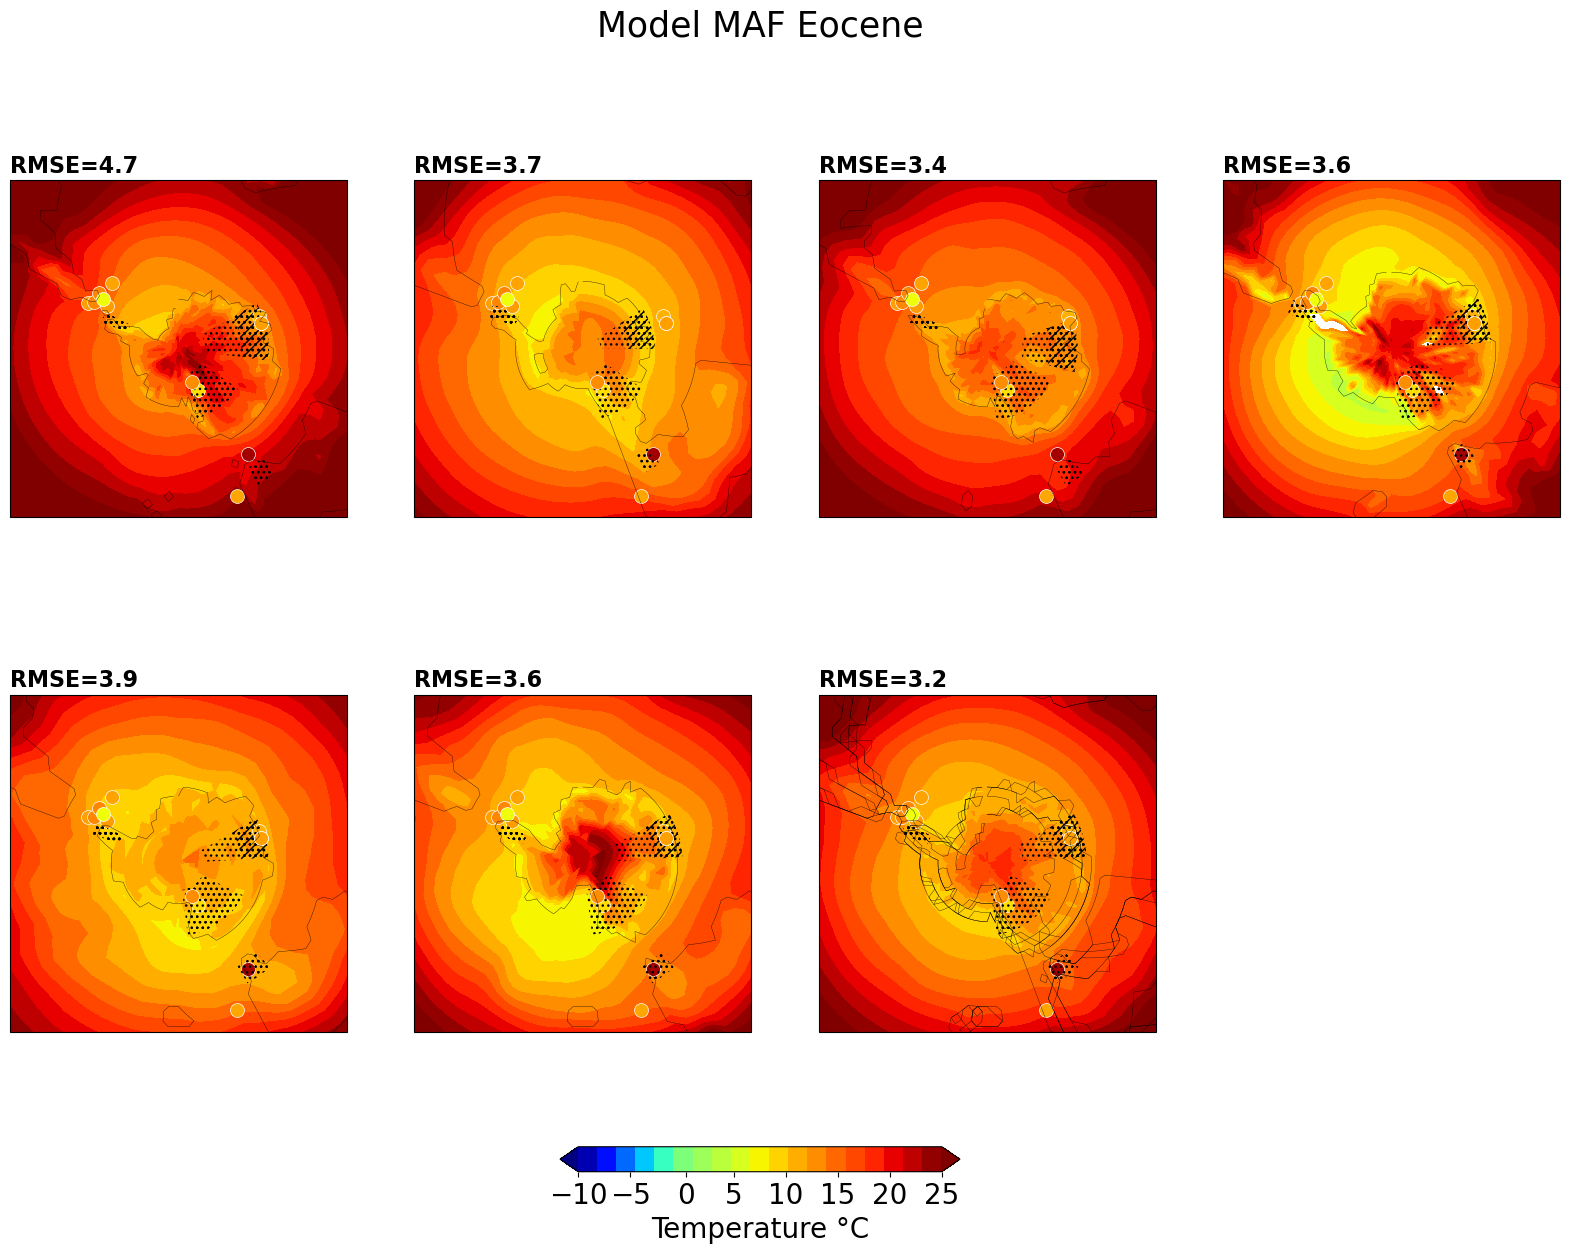

In [33]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=25)

for j in range(0,len(SATmodel_EO)):
    var = SATmodel_EO[j,:,:]

# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=SATmodel_EO.longitude)

# Make a filled contour plot
    datlist=list([0,1,2,3,4,5,6,7,8,9,10,11,12])
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap='jet',norm=norm,levels=np.linspace(-10,25,20),extend='both')
# Add coastlines
    coast=landmask_4x[j,:,:]*1
    if j==6:
        for k in range(0,6):
            coast_all=landmask_4x[k,:,:]*1
            ax.contour(landmask_4x.longitude,landmask_4x.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    else:
        ax.contour(landmask_4x.longitude,landmask_4x.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_Eocene[j]),fontweight='bold', fontsize=16,loc='left')
    
    for h in (datlist):
        circ,lon= add_cyclic_point(circles_Eocene[h,j],coord=SATmodel_EO[j].longitude)
        ca=ax.contourf(lon,var.latitude,circ ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none' ,hatches=['...'])
        if h==0:
            ca=ax.contourf(lon,var.latitude,circ ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none' ,hatches=['///'])
#Add in proxy datapoints and new point locations   
        cd=ax.scatter(Eocene_proxy_SAT['Paleolongitude'][h],Eocene_proxy_SAT['Paleolatitude'][h],c=Eocene_proxy_SAT['Eocene SAT'][h],s=100,cmap='jet',norm=norm,edgecolor='white',linewidth=0.5,transform=ccrs.PlateCarree())
      
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5,10,15,20,25,30,35,40])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model MAF Eocene',fontsize=25)
plt.savefig('SAT_CO2EoceneMAF_proxyMATmodel.pdf')

Oligocene

In [34]:
Oligo_proxy_SAT = EOT_proxy_SAT[EOT_proxy_SAT['Oligo SAT'].notnull()].reset_index(drop=True)

In [35]:
Oligo_proxy_SAT['Paleolongitude'][6]=315

In [36]:
Oligo_proxy_SAT0=Oligo_proxy_SAT[:]
Oligo_proxy_SAT1=Oligo_proxy_SAT[:]
Oligo_proxy_SAT2=Oligo_proxy_SAT[:]
Oligo_proxy_SAT3=Oligo_proxy_SAT[:]
Oligo_proxy_SAT4=Oligo_proxy_SAT[:]
Oligo_proxy_SAT5=Oligo_proxy_SAT[:]
Oligo_proxy_SAT6=Oligo_proxy_SAT[:]

In [37]:
#1st model
Oligo_proxy_SAT0['New paleolat']=Oligo_proxy_SAT0['Paleolatitude']
Oligo_proxy_SAT0['New paleolon']=Oligo_proxy_SAT0['Paleolongitude']

latchange=[-7,-7,0,-4,5,0,-10,-3]
lonchange=[5,5,-10,0,0,-10,-25,-12]
for i in range(0,8):
        Oligo_proxy_SAT0['New paleolat'][i]=Oligo_proxy_SAT0['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT0['New paleolon'][i]=Oligo_proxy_SAT0['Paleolongitude'][i]+lonchange[i]

#2nd model
Oligo_proxy_SAT1['New paleolat']=Oligo_proxy_SAT1['Paleolatitude']
Oligo_proxy_SAT1['New paleolon']=Oligo_proxy_SAT1['Paleolongitude']

latchange=[-12,-12,0,-10,-3,0,-5,-11]
lonchange=[0,0,0,3,2.5,0,-25,-10]
for i in range(0,8):
        Oligo_proxy_SAT1['New paleolat'][i]=Oligo_proxy_SAT1['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT1['New paleolon'][i]=Oligo_proxy_SAT1['Paleolongitude'][i]+lonchange[i]
        
#3rd model        
Oligo_proxy_SAT2['New paleolat']=Oligo_proxy_SAT2['Paleolatitude']
Oligo_proxy_SAT2['New paleolon']=Oligo_proxy_SAT2['Paleolongitude']

latchange=[-8,-8,0,-4,5,0,-5,-3]
lonchange=[15,15,0,0,2,0,-22,-10]
for i in range(0,8):
        Oligo_proxy_SAT2['New paleolat'][i]=Oligo_proxy_SAT2['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT2['New paleolon'][i]=Oligo_proxy_SAT2['Paleolongitude'][i]+lonchange[i]
#4th model        
Oligo_proxy_SAT3['New paleolat']=Oligo_proxy_SAT3['Paleolatitude']
Oligo_proxy_SAT3['New paleolon']=Oligo_proxy_SAT3['Paleolongitude']

latchange=[-5,-5,0,-4,0,0,0,-8]
lonchange=[0,0,0,0,0,0,-20,-12]
for i in range(0,8):
        Oligo_proxy_SAT3['New paleolat'][i]=Oligo_proxy_SAT3['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT3['New paleolon'][i]=Oligo_proxy_SAT3['Paleolongitude'][i]+lonchange[i]
        
#5th model        
Oligo_proxy_SAT4['New paleolat']=Oligo_proxy_SAT4['Paleolatitude']
Oligo_proxy_SAT4['New paleolon']=Oligo_proxy_SAT4['Paleolongitude']

latchange=[-7,-7,0,-6,0,0,-5,-8]
lonchange=[0,0,0,0,-2,0,-22,-14]
for i in range(0,8):
        Oligo_proxy_SAT4['New paleolat'][i]=Oligo_proxy_SAT4['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT4['New paleolon'][i]=Oligo_proxy_SAT4['Paleolongitude'][i]+lonchange[i]
        
#6th model        
Oligo_proxy_SAT5['New paleolat']=Oligo_proxy_SAT5['Paleolatitude']
Oligo_proxy_SAT5['New paleolon']=Oligo_proxy_SAT5['Paleolongitude']

latchange=[-6,-6,0,-4,0,0,-5,-8]
lonchange=[0,0,0,0,0,0,-20,-12]
for i in range(0,8):
        Oligo_proxy_SAT5['New paleolat'][i]=Oligo_proxy_SAT5['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT5['New paleolon'][i]=Oligo_proxy_SAT5['Paleolongitude'][i]+lonchange[i]
        
#7th model ensemble average       
Oligo_proxy_SAT6['New paleolat']=Oligo_proxy_SAT6['Paleolatitude']
Oligo_proxy_SAT6['New paleolon']=Oligo_proxy_SAT6['Paleolongitude']

latchange=[-5,-5,0,-4,0,0,-5,-8]
lonchange=[0,0,0,0,0,0,-23,-12]
for i in range(0,8):
        Oligo_proxy_SAT6['New paleolat'][i]=Oligo_proxy_SAT6['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT6['New paleolon'][i]=Oligo_proxy_SAT6['Paleolongitude'][i]+lonchange[i]

/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [38]:
Oligo_proxy_SAT0=Oligo_proxy_SAT0.to_xarray()
Oligo_proxy_SAT1=Oligo_proxy_SAT1.to_xarray()
Oligo_proxy_SAT2=Oligo_proxy_SAT2.to_xarray()
Oligo_proxy_SAT3=Oligo_proxy_SAT3.to_xarray()
Oligo_proxy_SAT4=Oligo_proxy_SAT4.to_xarray()
Oligo_proxy_SAT5=Oligo_proxy_SAT5.to_xarray()
Oligo_proxy_SAT6=Oligo_proxy_SAT6.to_xarray()

Oligo_SAT=Oligo_proxy_SAT0.expand_dims(dim='nmodels')
Oligo_SAT=xr.concat([Oligo_SAT,Oligo_proxy_SAT1],'nmodels')
Oligo_SAT=xr.concat([Oligo_SAT,Oligo_proxy_SAT2],'nmodels')
Oligo_SAT=xr.concat([Oligo_SAT,Oligo_proxy_SAT3],'nmodels')
Oligo_SAT=xr.concat([Oligo_SAT,Oligo_proxy_SAT4],'nmodels')
Oligo_SAT=xr.concat([Oligo_SAT,Oligo_proxy_SAT5],'nmodels')
Oligo_SAT=xr.concat([Oligo_SAT,Oligo_proxy_SAT6],'nmodels')

In [39]:
#Source area for Oligocene timeslices
datlist=list([0,1,2,3,4,5,6,7])
lats=range(0,73)
lons=range(0,96)
lat=SAT_conc4x.latitude
lon=SAT_conc4x.longitude
circles_Oligo=np.empty([8,7,73,96])
circles_Oligo=xr.DataArray(circles_Oligo,dims=['nproxies','nmodels','latitude','longitude'])

for j in range(0,len(SATmodel_Oligo)):
    for i in (datlist):
        arr=np.zeros((len(lats),len(lons))) #domain of zeroes
        originlat=Oligo_SAT['New paleolat'][j][datlist][i] #circle center lat
        originlon=Oligo_SAT['New paleolon'][j][datlist][i] #circle center lon
        if i==0 or i==1:
            if j==0:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<15
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<10
                masklatl = (SATmodel_Oligo[j].latitude[lats]-originlat)>2
                arr[masklat & masklatl & masklon] = 1
            if j==1:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<20
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<7
                masklatl = (SATmodel_Oligo[j].latitude[lats]-originlat)>2
                arr[masklat & masklatl & masklon] = 1
            if j==2:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<15
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<10
                masklatl = (SATmodel_Oligo[j].latitude[lats]-originlat)>2
                arr[masklat & masklatl & masklon] = 1
            if j==3 or j==4 or j==5 or j==6:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<15
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<10
                masklatl = (SATmodel_Oligo[j].latitude[lats]-originlat)>2
                arr[masklat & masklatl & masklon] = 1
        if i==2 or i==5:
            if j==1:
                masklon = (SATmodel_Oligo[j].longitude[lons]- originlon)<15
                masklonl= (SATmodel_Oligo[j].longitude[lons]- originlon)>0
                masklat = (SATmodel_Oligo[j].latitude[lats]-originlat)<8
                masklatl = (SATmodel_Oligo[j].latitude[lats]-originlat)>-5
                arr[masklat & masklatl & masklon & masklonl] = 1
            if j==0 or j==2 or j==3 or j==4 or j==5 or j==6:
                masklon = (SATmodel_Oligo[j].longitude[lons]- originlon)<15
                masklonl= (SATmodel_Oligo[j].longitude[lons]- originlon)>0
                masklat = (SATmodel_Oligo[j].latitude[lats]-originlat)<8
                masklatl = (SATmodel_Oligo[j].latitude[lats]-originlat)>-5
                arr[masklat & masklatl & masklon & masklonl] = 1
        if i==3:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<10
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<5
                arr[masklat & masklon] = 1
                arr[masklat & masklon] = 1
        if i==4:
            if j==0 or j==2 or j==3 or j==4 or j==5 or j==6:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<5.5
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
            if j==1:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<7
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
        if i==6:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<6
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<5
                arr[masklat & masklon] = 1
        if i==7:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<6
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<5
                arr[masklat & masklon] = 1
        arr = np.where(SATmodel_Oligo[j][lats,lons]!='nan',arr,0)
        arr = np.where(arr==0,np.nan,1)
        circles_Oligo[i,j,:,:]=arr; del arr 

In [40]:
datlist=list([0,1,2,3,4,5,6,7])
prox=np.empty((8))
array=np.empty((8,7,73,96))
Oligo_modelSAT=xr.DataArray(array,dims=['nproxies','nmodels','latitude','longitude'])
for ex in range(0,len(SATmodel_Oligo)):
    for i in range(len(datlist)):
        Oligo_temp= SATmodel_Oligo[ex][:,:]
        Oligo_modelSAT[i,ex,:,:]=np.where(circles_Oligo[i,ex,:,:]==1, Oligo_temp, np.nan)
        prox[i] = Oligo_proxy_SAT['Oligo SAT'][datlist][i]
        

Oligo_modelSAT['latitude']=SATmodel_Oligo.latitude
Oligo_modelSAT['longitude']=SATmodel_Oligo.longitude 

weights=np.cos(np.deg2rad(SATmodel_Oligo.latitude))
SAT_weighted=Oligo_modelSAT.weighted(weights)
Oligo_weighted_SAT = SAT_weighted.mean(dim=("longitude","latitude"))

errors=np.empty((8,7))
rms_Oligo=np.empty((7))
for ex in range(0,len(SATmodel_Oligo)):
        errors[:,ex]=(Oligo_weighted_SAT[:,ex]-prox[:])
        rms_Oligo[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(datlist)).round(decimals=1) 
rms_Oligo


array([5.3, 4.6, 4. , 3.7, 4.5, 3.4, 3.5])

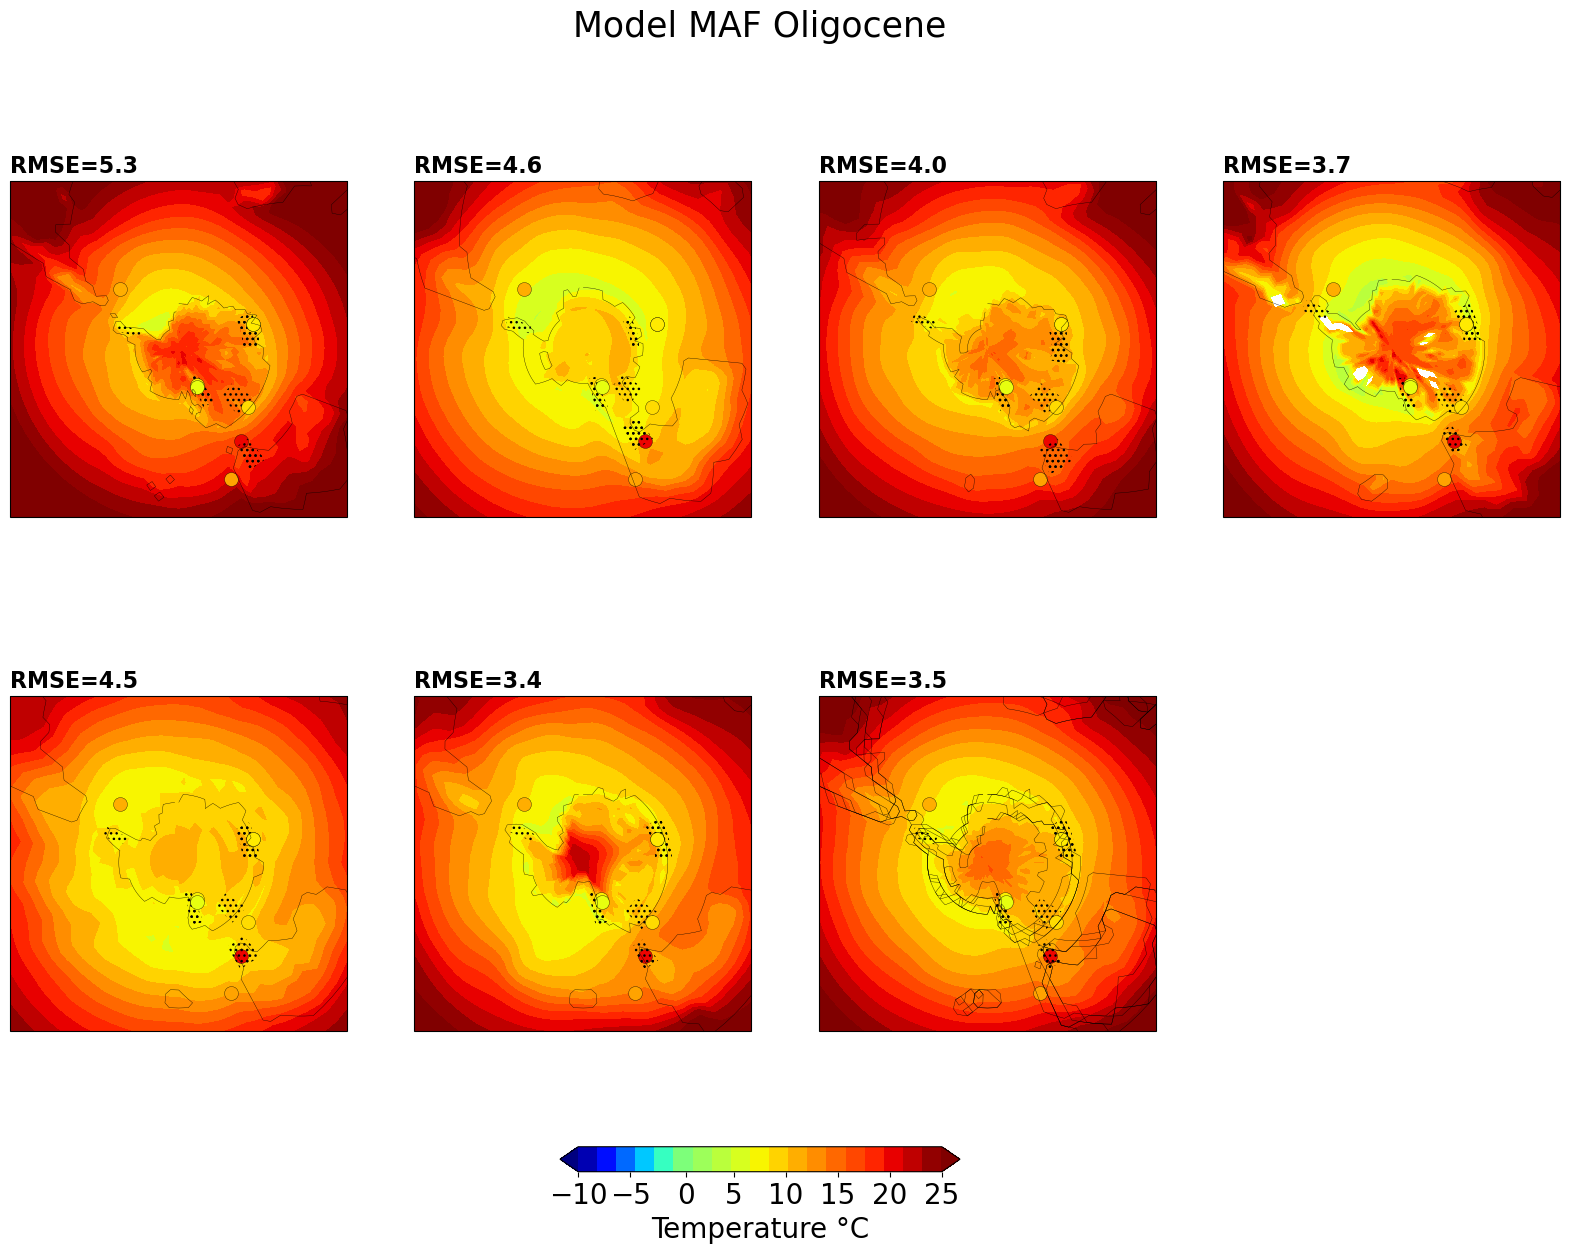

In [41]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=25)

for j in range(0,len(SATmodel_Oligo)):
    var = SATmodel_Oligo[j,:,:]

# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=SATmodel_Oligo.longitude)

# Make a filled contour plot
    datlist=list([0,1,2,3,4,5,6,7])
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap='jet',norm=norm,levels=np.linspace(-10,25,20),extend='both')
# Add coastlines
    if j==6:
        for k in range(0,6):
            coast_all=landmask_2x[k,:,:]*1
            ax.contour(landmask_2x.longitude,landmask_2x.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    else:
        coast=landmask_2x[j,:,:]*1
        ax.contour(landmask_2x.longitude,landmask_2x.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_Oligo[j]),fontweight='bold', fontsize=16,loc='left')
    
    for h in (datlist):
        circ,lon= add_cyclic_point(circles_Oligo[h,j],coord=SATmodel_Oligo[j].longitude)
        ca=ax.contourf(lon,var.latitude,circ ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none' ,hatches=['...'])
#Add in proxy datapoints and new point locations
        cd=ax.scatter(Oligo_proxy_SAT['Paleolongitude'][h],Oligo_proxy_SAT['Paleolatitude'][h],c=Oligo_proxy_SAT['Oligo SAT'][h],s=100,cmap='jet',norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
       
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5,10,15,20,25,30,35,40])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model MAF Oligocene',fontsize=25)
plt.savefig('SAT_CO2OligoceneMAF_proxyMATmodel.pdf')

EOT difference plots

In [42]:
#create separate datafiles for each model for the proxy input to adjust paleocoordinates and model averaging
proxy_SAT=EOT_proxy_SAT.dropna().reset_index(drop=True)
proxy_SAT_0=proxy_SAT[:]
proxy_SAT_1=proxy_SAT[:]
proxy_SAT_2=proxy_SAT[:]
proxy_SAT_3=proxy_SAT[:]
proxy_SAT_4=proxy_SAT[:]
proxy_SAT_5=proxy_SAT[:]
proxy_SAT_6=proxy_SAT[:]

In [43]:
#1st model
proxy_SAT_0['New paleolat']=proxy_SAT_0['Paleolatitude']
proxy_SAT_0['New paleolon']=proxy_SAT_0['Paleolongitude']

latchange=[-7,-7,0,5,-10,-3]
lonchange=[5,5,-10,0,-18,-12]
for i in range(0,6):
        proxy_SAT_0['New paleolat'][i]=proxy_SAT_0['Paleolatitude'][i]+latchange[i]
        proxy_SAT_0['New paleolon'][i]=proxy_SAT_0['Paleolongitude'][i]+lonchange[i]

#2nd model
proxy_SAT_1['New paleolat']=proxy_SAT_1['Paleolatitude']
proxy_SAT_1['New paleolon']=proxy_SAT_1['Paleolongitude']

latchange=[-12,-12,0,-3,-5,-11]
lonchange=[0,0,0,2.5,-18,-10]
for i in range(0,6):
        proxy_SAT_1['New paleolat'][i]=proxy_SAT_1['Paleolatitude'][i]+latchange[i]
        proxy_SAT_1['New paleolon'][i]=proxy_SAT_1['Paleolongitude'][i]+lonchange[i]

#3rd model        
proxy_SAT_2['New paleolat']=proxy_SAT_2['Paleolatitude']
proxy_SAT_2['New paleolon']=proxy_SAT_2['Paleolongitude']
latchange=[-8,-8,0,5,-5,-3]
lonchange=[15,15,0,2,-15,-10]
for i in range(0,6):
        proxy_SAT_2['New paleolat'][i]=proxy_SAT_2['Paleolatitude'][i]+latchange[i]
        proxy_SAT_2['New paleolon'][i]=proxy_SAT_2['Paleolongitude'][i]+lonchange[i]

#4th model        
proxy_SAT_3['New paleolat']=proxy_SAT_3['Paleolatitude']
proxy_SAT_3['New paleolon']=proxy_SAT_3['Paleolongitude']        
latchange=[-5,-5,0,0,-2,-8]
lonchange=[0,0,0,0,-13,-12]
for i in range(0,6):
        proxy_SAT_3['New paleolat'][i]=proxy_SAT_3['Paleolatitude'][i]+latchange[i]
        proxy_SAT_3['New paleolon'][i]=proxy_SAT_3['Paleolongitude'][i]+lonchange[i]
        
#5th model        
proxy_SAT_4['New paleolat']=proxy_SAT_4['Paleolatitude']
proxy_SAT_4['New paleolon']=proxy_SAT_4['Paleolongitude']        
latchange=[-7,-7,0,0,-5,-8]
lonchange=[0,0,0,-2,-15,-14]
for i in range(0,6):
        proxy_SAT_4['New paleolat'][i]=proxy_SAT_4['Paleolatitude'][i]+latchange[i]
        proxy_SAT_4['New paleolon'][i]=proxy_SAT_4['Paleolongitude'][i]+lonchange[i]
        
#6th model        
proxy_SAT_5['New paleolat']=proxy_SAT_5['Paleolatitude']
proxy_SAT_5['New paleolon']=proxy_SAT_5['Paleolongitude']        
latchange=[-6,-6,0,0,-5,-8]
lonchange=[0,0,0,0,-13,-12]
for i in range(0,6):
        proxy_SAT_5['New paleolat'][i]=proxy_SAT_5['Paleolatitude'][i]+latchange[i]
        proxy_SAT_5['New paleolon'][i]=proxy_SAT_5['Paleolongitude'][i]+lonchange[i]
        
#7th model ensemble average       
proxy_SAT_6['New paleolat']=proxy_SAT_6['Paleolatitude']
proxy_SAT_6['New paleolon']=proxy_SAT_6['Paleolongitude']        
latchange=[-5,-5,0,0,-5,-8]
lonchange=[0,0,0,0,-16,-12]
for i in range(0,6):
        proxy_SAT_6['New paleolat'][i]=proxy_SAT_6['Paleolatitude'][i]+latchange[i]
        proxy_SAT_6['New paleolon'][i]=proxy_SAT_6['Paleolongitude'][i]+lonchange[i]

/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [44]:
proxy_SAT_0=proxy_SAT_0.to_xarray()
proxy_SAT_1=proxy_SAT_1.to_xarray()
proxy_SAT_2=proxy_SAT_2.to_xarray()
proxy_SAT_3=proxy_SAT_3.to_xarray()
proxy_SAT_4=proxy_SAT_4.to_xarray()
proxy_SAT_5=proxy_SAT_5.to_xarray()
proxy_SAT_6=proxy_SAT_6.to_xarray()

SAT_proxy=proxy_SAT_0.expand_dims(dim='nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_1],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_2],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_3],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_4],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_5],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_6],'nmodels')

In [45]:
proxy_SAT['Paleolongitude'][0]=69
proxy_SAT['Paleolongitude'][2]=150

In [46]:
#drop 3 and 5
Oligo_0=Oligo_weighted_SAT.drop([5],dim='nproxies')
Oligoco2_weightadjust=Oligo_0.drop([3],dim='nproxies')

In [47]:
#adjust Oligocene circles as well
circles_Oligo=circles_Oligo.drop([5],dim='nproxies')
circles_Oligo=circles_Oligo.drop([3],dim='nproxies')

In [48]:
#drop 4 through 10
EO_0=EO_weighted_SAT.drop([10],dim='nproxies')
EO_1=EO_0.drop(9,dim='nproxies')
EO_2=EO_1.drop(8,dim='nproxies')
EO_3=EO_2.drop(7,dim='nproxies')
EO_4=EO_3.drop(6,dim='nproxies')
EO_5=EO_4.drop(5,dim='nproxies')
EOco2_weightadjust=EO_5.drop(4,dim='nproxies')

In [49]:
#adjust Eocene as well
circles_Eocene=circles_Eocene.drop([10,9,8,7,6,5,4],dim='nproxies')

In [50]:
EOTco2_diffadjust=Oligoco2_weightadjust-EOco2_weightadjust
prox=proxy_SAT['EOT diff']
datlist=list([0,1,2,3,4,5])
errors=np.empty((6,7))
rms_diffSAT=np.empty((7))
prox=np.empty((6))
for i in range(0, len(datlist)):
    prox[i] = proxy_SAT['EOT diff'][datlist][i]
    
for ex in range(0,len(diff_modelconc_SAT)):
    errors[:,ex]=(EOTco2_diffadjust[:,ex]-prox[:])
    rms_diffSAT[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(datlist)).round(decimals=1)
rms_diffSAT

array([2.4, 2.5, 2.7, 1.8, 2. , 2. , 2.1])

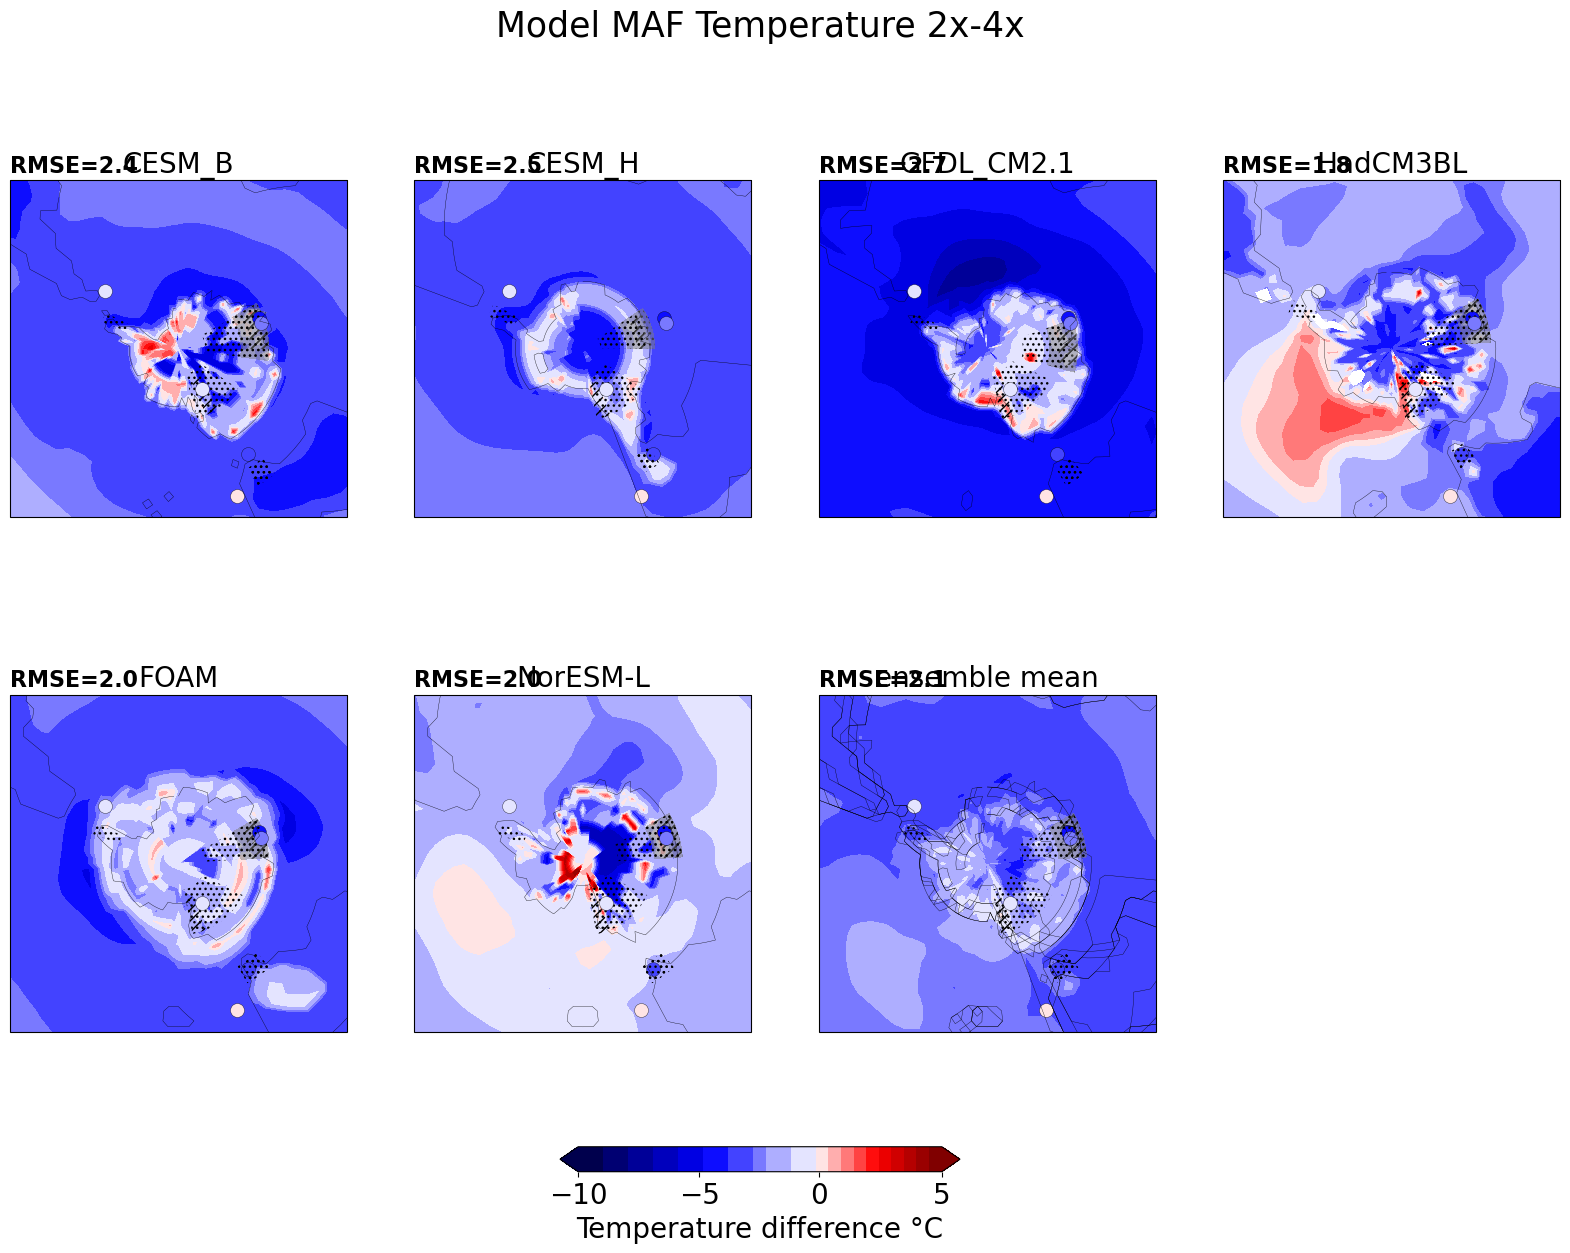

In [51]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=5)

for j in range(0,len(diff_modelconc_SAT)):
    var = diff_modelconc_SAT[j][lats,lons]

# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=diff_modelconc_SAT[j].longitude)

# Make a filled contour plot
    datlist=[0,1,2,3,4,5]
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,5,30),extend='both')
    if j==6:
        for k in range(0,6):
            coast_all=landmask_4x[k,:,:]*1
            ax.contour(landmask_4x.longitude,landmask_4x.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title("ensemble mean", fontsize=20)
    else:
        coast=landmask_4x[j,:,:]*1
        ax.contour(landmask_4x.longitude,landmask_4x.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        ax.set_title(model_high[j], fontsize=20)
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_diffSAT[j]),fontweight='bold', fontsize=16,loc='left')
#add hatching to distinguish the Eocene and Oligocene source areas
    datlist_Oligo=list([0,1,2,3,4,5])
    for i in (datlist_Oligo):
        circ,lon= add_cyclic_point(circles_Oligo[i,j],coord=SATmodel_Oligo[j].longitude)
        if i==3 or i==4 or i==5:
            continue
        ca=ax.contourf(lon,var.latitude,circ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none',hatches=['///'])
    for h in (datlist):   
        circ_E,lon= add_cyclic_point(circles_Eocene[h,j],coord=SATmodel_EO[j].longitude)
        cb=ax.contourf(lon,var.latitude,circ_E ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none',hatches=['...'])
        if h==0:
            cb=ax.contourf(lon,var.latitude,circ_E ,transform = ccrs.PlateCarree(), levels=[0,1],colors='grey',alpha=0.5,hatches=[None])
#Add in proxy datapoints and new point locations
        cd=ax.scatter(proxy_SAT['Paleolongitude'][h],proxy_SAT['Paleolatitude'][h],c=proxy_SAT['EOT diff'][h],s=100,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())

colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model MAF Temperature 2x-4x',fontsize=25)
plt.savefig('SAT_tempdiffMAF_proxyMATmodel.pdf')

Estimating pCO2 drop using MAF from models with all proxies as MAT

In [52]:
#create testarray for scaling
nxx=101
testarray=np.linspace(0,2,nxx)

In [53]:
def SKILL(my_mod,my_dat,ncols):
    ans=math.sqrt(sum((my_mod-my_dat)*(my_mod-my_dat))/(1.0*ncols)) #ncols corresponds to the proxy data RMSE
    return ans

In [54]:
array=np.empty((101,6,7))
vect=xr.DataArray(array,dims=['nxx','nproxies','nmodels'])
for j in range (0,len(testarray)):
    for i in range (0,len(EOTco2_diffadjust)):
        vect[j,i,:]=testarray[j]*EOTco2_diffadjust[i,:]

Calculate RMSE

In [55]:
errs_1d=np.empty((101,7))
for i in range(0,len(vect.nxx)):
    for j in range(0,len(vect.nmodels)):
        errs_1d[i,j]=SKILL(vect[i,:,j],proxy_SAT['EOT diff'],6)
        
inval_1d=np.min(errs_1d,axis=0)
ind_1d=np.argmin(errs_1d,axis=0)
print(inval_1d)

[1.67364591 1.76288032 1.88985659 1.42346737 1.82428776 1.70614453
 1.58935252]


Estimated CO2 drop

In [56]:
CO2drop=560*2**testarray[ind_1d]
percentdecrease=(CO2drop-560)/CO2drop*100
print(CO2drop,percentdecrease)

Co2change=CO2drop-560
print(Co2change)

[781.05645316 781.05645316 749.23943068 872.66432922 897.1982629
 848.80127725 825.59076168] [28.3022376  28.3022376  25.25753757 35.82870512 37.58347255 34.02460446
 32.16978363]
[221.05645316 221.05645316 189.23943068 312.66432922 337.1982629
 288.80127725 265.59076168]


Input MAF proxy to compare improvement with MAF for both proxies and model (only 1 proxy was able to be converted to MAF)

In [57]:
EOT_proxy_SST=pd.read_csv('/homes/etibbett/EOT_data_share/EOT_temperaturecomparison_pythonMAF_4.11.csv',header=0,usecols=['Paleolatitude','Paleolongitude','Oligo SST','Eocene SST'])
EOT_proxy_SAT=pd.read_csv('/homes/etibbett/EOT_data_share/EOT_temperaturecomparison_pythonMAF_4.11.csv',header=0,usecols=['Paleolatitude','Paleolongitude','Oligo SAT','Eocene SAT'])


EOT_proxydiff_SST=EOT_proxy_SST['Oligo SST']-EOT_proxy_SST['Eocene SST']
EOT_proxydiff_SAT=EOT_proxy_SAT['Oligo SAT']-EOT_proxy_SAT['Eocene SAT']

proxydiff_SST=EOT_proxydiff_SST.dropna()
SST_proxydiff=proxydiff_SST.to_xarray()
proxydiff_SAT=EOT_proxydiff_SAT.dropna()
SAT_proxydiff=proxydiff_SAT.to_xarray()

SAT_proxy=EOT_proxy_SAT.dropna()
proxy_SAT=SAT_proxy.to_xarray()

SST_proxy=EOT_proxy_SST.dropna()
proxy_SST=SST_proxy.to_xarray()

EOT_proxy_SAT['EOT diff']=EOT_proxy_SAT['Oligo SAT']-EOT_proxy_SAT['Eocene SAT']
EOT_proxy_SST['EOT diff']=EOT_proxy_SST['Oligo SST']-EOT_proxy_SST['Eocene SST']


Calculate RMSE for each timeslice for MAF (values reported in article supplement)

Eocene

In [58]:
Eocene_proxy_SAT = EOT_proxy_SAT[EOT_proxy_SAT['Eocene SAT'].notnull()].reset_index(drop=True)

In [59]:
#create separate datafiles for each model for the proxy input to adjust paleocoordinates and model averaging
Eocene_proxy_SAT0=Eocene_proxy_SAT[:]
Eocene_proxy_SAT1=Eocene_proxy_SAT[:]
Eocene_proxy_SAT2=Eocene_proxy_SAT[:]
Eocene_proxy_SAT3=Eocene_proxy_SAT[:]
Eocene_proxy_SAT4=Eocene_proxy_SAT[:]
Eocene_proxy_SAT5=Eocene_proxy_SAT[:]
Eocene_proxy_SAT6=Eocene_proxy_SAT[:]

In [60]:
#1st model
Eocene_proxy_SAT0['New paleolat']=Eocene_proxy_SAT0['Paleolatitude']
Eocene_proxy_SAT0['New paleolon']=Eocene_proxy_SAT0['Paleolongitude']

latchange=[-7,-7,0,5,-5,-7,-7,0,-7,-7,-5,-6,-3]
lonchange=[5,5,-4,0,-8,-5,-5,-7,-6,5,-10,-15,-12]
for i in range(0,13):
        Eocene_proxy_SAT0['New paleolat'][i]=Eocene_proxy_SAT0['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT0['New paleolon'][i]=Eocene_proxy_SAT0['Paleolongitude'][i]+lonchange[i]

#2nd model
Eocene_proxy_SAT1['New paleolat']=Eocene_proxy_SAT1['Paleolatitude']
Eocene_proxy_SAT1['New paleolon']=Eocene_proxy_SAT1['Paleolongitude']


latchange=[-12,-12,0,0,-1,-3,-3,0,-3,-12,-1,-2,-8]
lonchange=[0,0,-4,5,-9,-6,-6,-7,-7,0,-10,-16,-7]
for i in range(0,13):
        Eocene_proxy_SAT1['New paleolat'][i]=Eocene_proxy_SAT1['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT1['New paleolon'][i]=Eocene_proxy_SAT1['Paleolongitude'][i]+lonchange[i]
        
#3rd model        
Eocene_proxy_SAT2['New paleolat']=Eocene_proxy_SAT2['Paleolatitude']
Eocene_proxy_SAT2['New paleolon']=Eocene_proxy_SAT2['Paleolongitude']

latchange=[-8,-8,0,5,-5,-7,-7,0,-7,-8,-5,-6,-3]
lonchange=[15,15,0,0,-9,-6,-6,0,-7,15,-10,-16,-12]
for i in range(0,13):
        Eocene_proxy_SAT2['New paleolat'][i]=Eocene_proxy_SAT2['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT2['New paleolon'][i]=Eocene_proxy_SAT2['Paleolongitude'][i]+lonchange[i]

#4th model        
Eocene_proxy_SAT3['New paleolat']=Eocene_proxy_SAT3['Paleolatitude']
Eocene_proxy_SAT3['New paleolon']=Eocene_proxy_SAT3['Paleolongitude']

latchange=[-5,-5,0,0,2,0,0,0,0,-5,2,1,-8]
lonchange=[0,0,0,0,-8,-5,-5,0,-6,0,-10,-15,-12]
for i in range(0,13):
        Eocene_proxy_SAT3['New paleolat'][i]=Eocene_proxy_SAT3['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT3['New paleolon'][i]=Eocene_proxy_SAT3['Paleolongitude'][i]+lonchange[i]
        
#5th model        
Eocene_proxy_SAT4['New paleolat']=Eocene_proxy_SAT4['Paleolatitude']
Eocene_proxy_SAT4['New paleolon']=Eocene_proxy_SAT4['Paleolongitude']


latchange=[-7,-7,0,0,-4,-6,-6,0,-6,-7,-4,-5,-8]
lonchange=[0,0,0,-2,-9,-6,-6,0,-7,0,-11,-16,-14]
for i in range(0,13):
        Eocene_proxy_SAT4['New paleolat'][i]=Eocene_proxy_SAT4['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT4['New paleolon'][i]=Eocene_proxy_SAT4['Paleolongitude'][i]+lonchange[i]
        
#6th model        
Eocene_proxy_SAT5['New paleolat']=Eocene_proxy_SAT5['Paleolatitude']
Eocene_proxy_SAT5['New paleolon']=Eocene_proxy_SAT5['Paleolongitude']

latchange=[-6,-6,0,0,-4,-6,-6,0,-6,-6,-4,-5,-8]
lonchange=[0,0,0,-2,-9,-6,-6,0,-7,0,-11,-16,-14]
for i in range(0,13):
        Eocene_proxy_SAT5['New paleolat'][i]=Eocene_proxy_SAT5['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT5['New paleolon'][i]=Eocene_proxy_SAT5['Paleolongitude'][i]+lonchange[i]
        
#7th model ensemble average       
Eocene_proxy_SAT6['New paleolat']=Eocene_proxy_SAT6['Paleolatitude']
Eocene_proxy_SAT6['New paleolon']=Eocene_proxy_SAT6['Paleolongitude']

latchange=[-5,-5,0,0,-4,-6,-6,0,-6,-5,-4,-5,-8]
lonchange=[0,0,0,-2,-9,-6,-6,0,-7,0,-11,-16,-14]
for i in range(0,13):
        Eocene_proxy_SAT6['New paleolat'][i]=Eocene_proxy_SAT6['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT6['New paleolon'][i]=Eocene_proxy_SAT6['Paleolongitude'][i]+lonchange[i]

/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [61]:
Eocene_proxy_SAT0=Eocene_proxy_SAT0.to_xarray()
Eocene_proxy_SAT1=Eocene_proxy_SAT1.to_xarray()
Eocene_proxy_SAT2=Eocene_proxy_SAT2.to_xarray()
Eocene_proxy_SAT3=Eocene_proxy_SAT3.to_xarray()
Eocene_proxy_SAT4=Eocene_proxy_SAT4.to_xarray()
Eocene_proxy_SAT5=Eocene_proxy_SAT5.to_xarray()
Eocene_proxy_SAT6=Eocene_proxy_SAT6.to_xarray()

In [62]:
Eocene_SAT=Eocene_proxy_SAT0.expand_dims(dim='nmodels')
Eocene_SAT=xr.concat([Eocene_SAT,Eocene_proxy_SAT1],'nmodels')
Eocene_SAT=xr.concat([Eocene_SAT,Eocene_proxy_SAT2],'nmodels')
Eocene_SAT=xr.concat([Eocene_SAT,Eocene_proxy_SAT3],'nmodels')
Eocene_SAT=xr.concat([Eocene_SAT,Eocene_proxy_SAT4],'nmodels')
Eocene_SAT=xr.concat([Eocene_SAT,Eocene_proxy_SAT5],'nmodels')
Eocene_SAT=xr.concat([Eocene_SAT,Eocene_proxy_SAT6],'nmodels')

In [63]:
Eocene_proxy_SAT['Paleolongitude'][0]=68
Eocene_proxy_SAT['Paleolongitude'][5]=297
Eocene_proxy_SAT['Paleolatitude'][5]=-62
Eocene_proxy_SAT['Paleolatitude'][7]=-80
Eocene_proxy_SAT['Paleolatitude'][4]=-67
Eocene_proxy_SAT['Paleolongitude'][8]=305
Eocene_proxy_SAT['Paleolongitude'][11]=315

In [64]:
#identifies source area to compare to air temperatures calculated from ocean drilling cores
datlist=list([0,1,2,3,4,5,6,7,8,9,10,11,12])
lats=range(0,73)
lons=range(0,96)
lat=SATmodel_EO.latitude
lon=SATmodel_EO.longitude
circles_Eocene=np.empty([13,7,73,96])
circles_Eocene=xr.DataArray(circles_Eocene,dims=['nproxies','nmodels','latitude','longitude'])

for j in range(0,len(SATmodel_EO)):
    for i in (datlist):
        arr=np.zeros((len(lats),len(lons))) #domain of zeroes
        originlat=Eocene_SAT['New paleolat'][j][datlist][i] #circle center lat
        originlon=Eocene_SAT['New paleolon'][j][datlist][i] #circle center lon
        if i==0 or i==9:
            if j==0:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<21
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<8
                masklatl = (SATmodel_EO[j].latitude[lats]-originlat)>0
                arr[masklat & masklatl & masklon] = 1
            if j==1:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<20
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<8
                masklatl = (SATmodel_EO[j].latitude[lats]-originlat)>0
                arr[masklat & masklatl & masklon] = 1
            if j==2:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<20
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<10
                masklatl = (SATmodel_EO[j].latitude[lats]-originlat)>0
                arr[masklat & masklatl & masklon] = 1
            if j==3 or j==4 or j==5 or j==6:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<15
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<10
                masklatl = (SATmodel_EO[j].latitude[lats]-originlat)>0
                arr[masklat & masklatl & masklon] = 1
        if i==1:
            if j==0:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<21
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
            if j==1:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<20
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<7.5
                arr[masklat & masklon] = 1
            if j==2:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<20
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<8
                arr[masklat & masklon] = 1
            if j==3 or j==4 or j==5 or j==6:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<15
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
        if i==2 or i==7:
            if j==0 or j==1:
                masklon = (SATmodel_EO[j].longitude[lons]- originlon)<15
                masklonl= (SATmodel_EO[j].longitude[lons]- originlon)>-30
                masklat = (SATmodel_EO[j].latitude[lats]-originlat)<8
                masklatl = (SATmodel_EO[j].latitude[lats]-originlat)>-6
                arr[masklat & masklatl & masklon & masklonl] = 1
            if j==2 or j==3 or j==4 or j==5 or j==6:
                masklon = (SATmodel_EO[j].longitude[lons]- originlon)<17
                masklonl= (SATmodel_EO[j].longitude[lons]- originlon)>-40
                masklat = (SATmodel_EO[j].latitude[lats]-originlat)<8
                masklatl = (SATmodel_EO[j].latitude[lats]-originlat)>-6
                arr[masklat & masklatl & masklon & masklonl] = 1
        if i==3 or i==12: #-63.96,-53.91,2,7
            masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<6
            masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<4
            arr[masklat & masklon] = 1
        if i==4 or i==5 or i==6 or i==8 or i==10 or i==11:
            masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<6
            masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<5
            arr[masklat & masklon] = 1
        arr = np.where(SATmodel_EO[j][lats,lons]!='nan',arr,0)
        arr = np.where(arr==0,np.nan,1)
        circles_Eocene[i,j,:,:]=arr; del arr

In [65]:
datlist=list([0,1,2,3,4,5,6,7,8,9,10,11,12])
prox=np.empty((13))
array=np.empty((13,7,73,96))
EO_modelSAT=xr.DataArray(array,dims=['nproxies','nmodels','latitude','longitude'])
for ex in range(0,len(SATmodel_EO)):
    for i in range(len(datlist)):
        EO_temp= SATmodel_EO[ex][:,:]
        EO_modelSAT[i,ex,:,:]=np.where(circles_Eocene[i,ex,:,:]==1, EO_temp, np.nan)
        prox[i] = Eocene_proxy_SAT['Eocene SAT'][datlist][i]
        

EO_modelSAT['latitude']=SATmodel_EO.latitude
EO_modelSAT['longitude']=SATmodel_EO.longitude 

weights=np.cos(np.deg2rad(SATmodel_EO.latitude))
SAT_weighted=EO_modelSAT.weighted(weights)
EO_weighted_SAT = SAT_weighted.mean(dim=("longitude","latitude"))

errors=np.empty((13,7))
rms_Eocene=np.empty((7))
for ex in range(0,len(SATmodel_EO)):
        errors[:,ex]=(EO_weighted_SAT[:,ex]-prox[:])
        rms_Eocene[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(datlist)).round(decimals=1) 
rms_Eocene

array([4.5, 3.8, 3.1, 3.8, 4. , 3.7, 3.2])

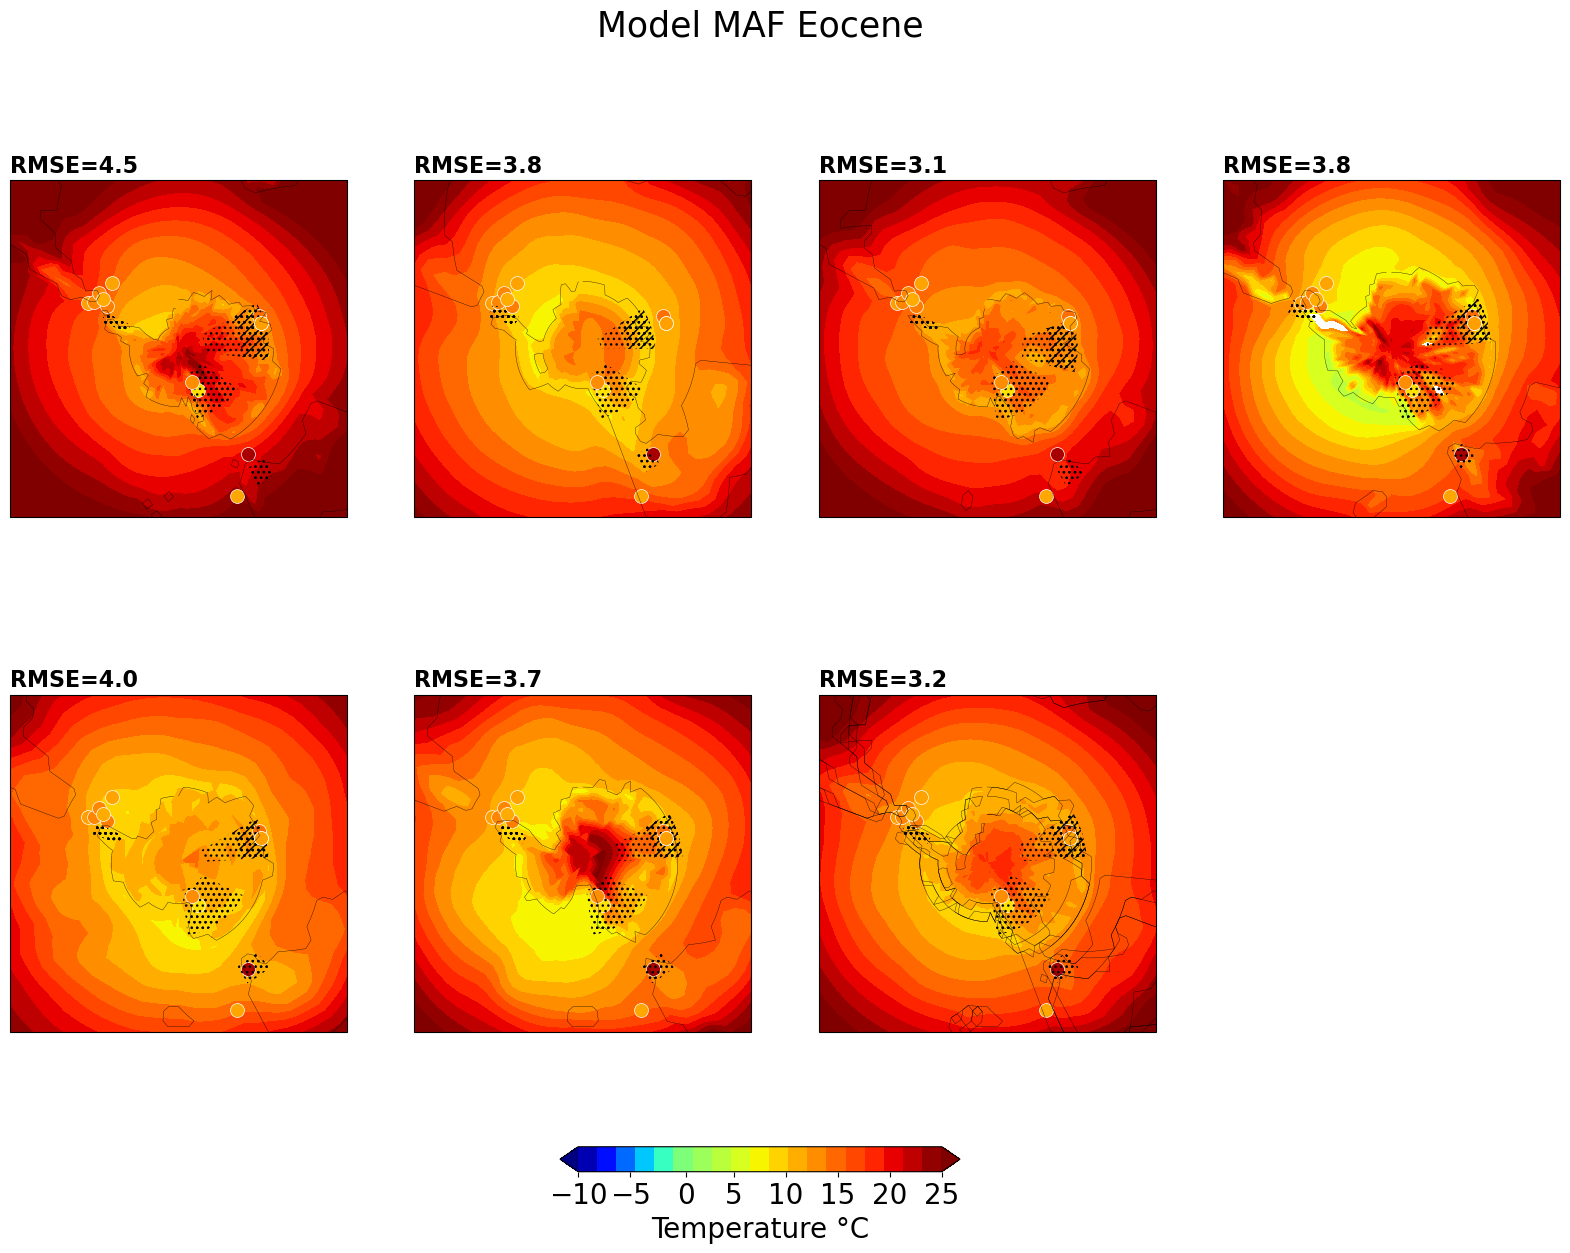

In [66]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=25)

for j in range(0,len(SATmodel_EO)):
    var = SATmodel_EO[j,:,:]

# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=SATmodel_EO.longitude)

# Make a filled contour plot
    datlist=list([0,1,2,3,4,5,6,7,8,9,10,11,12])
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap='jet',norm=norm,levels=np.linspace(-10,25,20),extend='both')
# Add coastlines
    coast=landmask_4x[j,:,:]*1
    if j==6:
        for k in range(0,5):
            coast_all=landmask_4x[k,:,:]*1
            ax.contour(landmask_4x.longitude,landmask_4x.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    else:
        ax.contour(landmask_4x.longitude,landmask_4x.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_Eocene[j]),fontweight='bold', fontsize=16,loc='left')
    
    for h in (datlist):
        circ,lon= add_cyclic_point(circles_Eocene[h,j],coord=SATmodel_EO[j].longitude)
        ca=ax.contourf(lon,var.latitude,circ ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none' ,hatches=['...'])
        if h==0:
            ca=ax.contourf(lon,var.latitude,circ ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none' ,hatches=['///'])
#Add in proxy datapoints and new point locations   
        cd=ax.scatter(Eocene_proxy_SAT['Paleolongitude'][h],Eocene_proxy_SAT['Paleolatitude'][h],c=Eocene_proxy_SAT['Eocene SAT'][h],s=100,cmap='jet',norm=norm,edgecolor='white',linewidth=0.5,transform=ccrs.PlateCarree())

colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5,10,15,20,25,30,35,40])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model MAF Eocene',fontsize=25)
plt.savefig('SAT_CO2EoceneMAF_proxymodel.pdf')

Oligocene

In [67]:
Oligo_proxy_SAT = EOT_proxy_SAT[EOT_proxy_SAT['Oligo SAT'].notnull()].reset_index(drop=True)

In [68]:
Oligo_proxy_SAT['Paleolongitude'][6]=315

In [69]:
Oligo_proxy_SAT0=Oligo_proxy_SAT[:]
Oligo_proxy_SAT1=Oligo_proxy_SAT[:]
Oligo_proxy_SAT2=Oligo_proxy_SAT[:]
Oligo_proxy_SAT3=Oligo_proxy_SAT[:]
Oligo_proxy_SAT4=Oligo_proxy_SAT[:]
Oligo_proxy_SAT5=Oligo_proxy_SAT[:]
Oligo_proxy_SAT6=Oligo_proxy_SAT[:]

In [70]:
#1st model
Oligo_proxy_SAT0['New paleolat']=Oligo_proxy_SAT0['Paleolatitude']
Oligo_proxy_SAT0['New paleolon']=Oligo_proxy_SAT0['Paleolongitude']

latchange=[-7,-7,0,-4,5,0,-10,-3]
lonchange=[5,5,-10,0,0,-10,-25,-12]
for i in range(0,8):
        Oligo_proxy_SAT0['New paleolat'][i]=Oligo_proxy_SAT0['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT0['New paleolon'][i]=Oligo_proxy_SAT0['Paleolongitude'][i]+lonchange[i]

#2nd model
Oligo_proxy_SAT1['New paleolat']=Oligo_proxy_SAT1['Paleolatitude']
Oligo_proxy_SAT1['New paleolon']=Oligo_proxy_SAT1['Paleolongitude']

latchange=[-12,-12,0,-10,-3,0,-5,-11]
lonchange=[0,0,0,3,2.5,0,-25,-10]
for i in range(0,8):
        Oligo_proxy_SAT1['New paleolat'][i]=Oligo_proxy_SAT1['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT1['New paleolon'][i]=Oligo_proxy_SAT1['Paleolongitude'][i]+lonchange[i]
        
#3rd model        
Oligo_proxy_SAT2['New paleolat']=Oligo_proxy_SAT2['Paleolatitude']
Oligo_proxy_SAT2['New paleolon']=Oligo_proxy_SAT2['Paleolongitude']

latchange=[-8,-8,0,-4,5,0,-5,-3]
lonchange=[15,15,0,0,2,0,-22,-10]
for i in range(0,8):
        Oligo_proxy_SAT2['New paleolat'][i]=Oligo_proxy_SAT2['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT2['New paleolon'][i]=Oligo_proxy_SAT2['Paleolongitude'][i]+lonchange[i]
#4th model        
Oligo_proxy_SAT3['New paleolat']=Oligo_proxy_SAT3['Paleolatitude']
Oligo_proxy_SAT3['New paleolon']=Oligo_proxy_SAT3['Paleolongitude']

latchange=[-5,-5,0,-4,0,0,0,-8]
lonchange=[0,0,0,0,0,0,-20,-12]
for i in range(0,8):
        Oligo_proxy_SAT3['New paleolat'][i]=Oligo_proxy_SAT3['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT3['New paleolon'][i]=Oligo_proxy_SAT3['Paleolongitude'][i]+lonchange[i]
        
#5th model        
Oligo_proxy_SAT4['New paleolat']=Oligo_proxy_SAT4['Paleolatitude']
Oligo_proxy_SAT4['New paleolon']=Oligo_proxy_SAT4['Paleolongitude']

latchange=[-7,-7,0,-6,0,0,-5,-8]
lonchange=[0,0,0,0,-2,0,-22,-14]
for i in range(0,8):
        Oligo_proxy_SAT4['New paleolat'][i]=Oligo_proxy_SAT4['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT4['New paleolon'][i]=Oligo_proxy_SAT4['Paleolongitude'][i]+lonchange[i]
        
#6th model        
Oligo_proxy_SAT5['New paleolat']=Oligo_proxy_SAT5['Paleolatitude']
Oligo_proxy_SAT5['New paleolon']=Oligo_proxy_SAT5['Paleolongitude']

latchange=[-6,-6,0,-4,0,0,-5,-8]
lonchange=[0,0,0,0,0,0,-20,-12]
for i in range(0,8):
        Oligo_proxy_SAT5['New paleolat'][i]=Oligo_proxy_SAT5['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT5['New paleolon'][i]=Oligo_proxy_SAT5['Paleolongitude'][i]+lonchange[i]
        
#7th model ensemble average       
Oligo_proxy_SAT6['New paleolat']=Oligo_proxy_SAT6['Paleolatitude']
Oligo_proxy_SAT6['New paleolon']=Oligo_proxy_SAT6['Paleolongitude']

latchange=[-5,-5,0,-4,0,0,-5,-8]
lonchange=[0,0,0,0,0,0,-23,-12]
for i in range(0,8):
        Oligo_proxy_SAT6['New paleolat'][i]=Oligo_proxy_SAT6['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT6['New paleolon'][i]=Oligo_proxy_SAT6['Paleolongitude'][i]+lonchange[i]

/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [71]:
Oligo_proxy_SAT0=Oligo_proxy_SAT0.to_xarray()
Oligo_proxy_SAT1=Oligo_proxy_SAT1.to_xarray()
Oligo_proxy_SAT2=Oligo_proxy_SAT2.to_xarray()
Oligo_proxy_SAT3=Oligo_proxy_SAT3.to_xarray()
Oligo_proxy_SAT4=Oligo_proxy_SAT4.to_xarray()
Oligo_proxy_SAT5=Oligo_proxy_SAT5.to_xarray()
Oligo_proxy_SAT6=Oligo_proxy_SAT6.to_xarray()

Oligo_SAT=Oligo_proxy_SAT0.expand_dims(dim='nmodels')
Oligo_SAT=xr.concat([Oligo_SAT,Oligo_proxy_SAT1],'nmodels')
Oligo_SAT=xr.concat([Oligo_SAT,Oligo_proxy_SAT2],'nmodels')
Oligo_SAT=xr.concat([Oligo_SAT,Oligo_proxy_SAT3],'nmodels')
Oligo_SAT=xr.concat([Oligo_SAT,Oligo_proxy_SAT4],'nmodels')
Oligo_SAT=xr.concat([Oligo_SAT,Oligo_proxy_SAT5],'nmodels')
Oligo_SAT=xr.concat([Oligo_SAT,Oligo_proxy_SAT6],'nmodels')

In [72]:
#Source area for Oligocene timeslices
datlist=list([0,1,2,3,4,5,6,7])
lats=range(0,73)
lons=range(0,96)
lat=SAT_conc4x.latitude
lon=SAT_conc4x.longitude
circles_Oligo=np.empty([8,7,73,96])
circles_Oligo=xr.DataArray(circles_Oligo,dims=['nproxies','nmodels','latitude','longitude'])

for j in range(0,len(SATmodel_Oligo)):
    for i in (datlist):
        arr=np.zeros((len(lats),len(lons))) #domain of zeroes
        originlat=Oligo_SAT['New paleolat'][j][datlist][i] #circle center lat
        originlon=Oligo_SAT['New paleolon'][j][datlist][i] #circle center lon
        if i==0 or i==1:
            if j==0:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<15
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<10
                masklatl = (SATmodel_Oligo[j].latitude[lats]-originlat)>2
                arr[masklat & masklatl & masklon] = 1
            if j==1:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<20
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<7
                masklatl = (SATmodel_Oligo[j].latitude[lats]-originlat)>2
                arr[masklat & masklatl & masklon] = 1
            if j==2:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<15
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<10
                masklatl = (SATmodel_Oligo[j].latitude[lats]-originlat)>2
                arr[masklat & masklatl & masklon] = 1
            if j==3 or j==4 or j==5 or j==6:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<15
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<10
                masklatl = (SATmodel_Oligo[j].latitude[lats]-originlat)>2
                arr[masklat & masklatl & masklon] = 1
        if i==2 or i==5:
            if j==1:
                masklon = (SATmodel_Oligo[j].longitude[lons]- originlon)<15
                masklonl= (SATmodel_Oligo[j].longitude[lons]- originlon)>0
                masklat = (SATmodel_Oligo[j].latitude[lats]-originlat)<8
                masklatl = (SATmodel_Oligo[j].latitude[lats]-originlat)>-5
                arr[masklat & masklatl & masklon & masklonl] = 1
            if j==0 or j==2 or j==3 or j==4 or j==5 or j==6:
                masklon = (SATmodel_Oligo[j].longitude[lons]- originlon)<15
                masklonl= (SATmodel_Oligo[j].longitude[lons]- originlon)>0
                masklat = (SATmodel_Oligo[j].latitude[lats]-originlat)<8
                masklatl = (SATmodel_Oligo[j].latitude[lats]-originlat)>-5
                arr[masklat & masklatl & masklon & masklonl] = 1
        if i==3:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<10
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<5
                arr[masklat & masklon] = 1
                arr[masklat & masklon] = 1
        if i==4:
            if j==0 or j==2 or j==3 or j==4 or j==5 or j==6:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<5.5
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
            if j==1:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<7
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
        if i==6:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<6
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<5
                arr[masklat & masklon] = 1
        if i==7:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<6
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<5
                arr[masklat & masklon] = 1
        arr = np.where(SATmodel_Oligo[j][lats,lons]!='nan',arr,0)
        arr = np.where(arr==0,np.nan,1)
        circles_Oligo[i,j,:,:]=arr; del arr 

In [73]:
datlist=list([0,1,2,3,4,5,6,7])
prox=np.empty((8))
array=np.empty((8,7,73,96))
Oligo_modelSAT=xr.DataArray(array,dims=['nproxies','nmodels','latitude','longitude'])
for ex in range(0,len(SATmodel_Oligo)):
    for i in range(len(datlist)):
        Oligo_temp= SATmodel_Oligo[ex][:,:]
        Oligo_modelSAT[i,ex,:,:]=np.where(circles_Oligo[i,ex,:,:]==1, Oligo_temp, np.nan)
        prox[i] = Oligo_proxy_SAT['Oligo SAT'][datlist][i]
        

Oligo_modelSAT['latitude']=SATmodel_Oligo.latitude
Oligo_modelSAT['longitude']=SATmodel_Oligo.longitude 

weights=np.cos(np.deg2rad(SATmodel_Oligo.latitude))
SAT_weighted=Oligo_modelSAT.weighted(weights)
Oligo_weighted_SAT = SAT_weighted.mean(dim=("longitude","latitude"))

errors=np.empty((8,7))
rms_Oligo=np.empty((7))
for ex in range(0,len(SATmodel_Oligo)):
        errors[:,ex]=(Oligo_weighted_SAT[:,ex]-prox[:])
        rms_Oligo[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(datlist)).round(decimals=1) 
rms_Oligo


array([5.1, 4.6, 3.6, 3.8, 4.3, 3.2, 3.4])

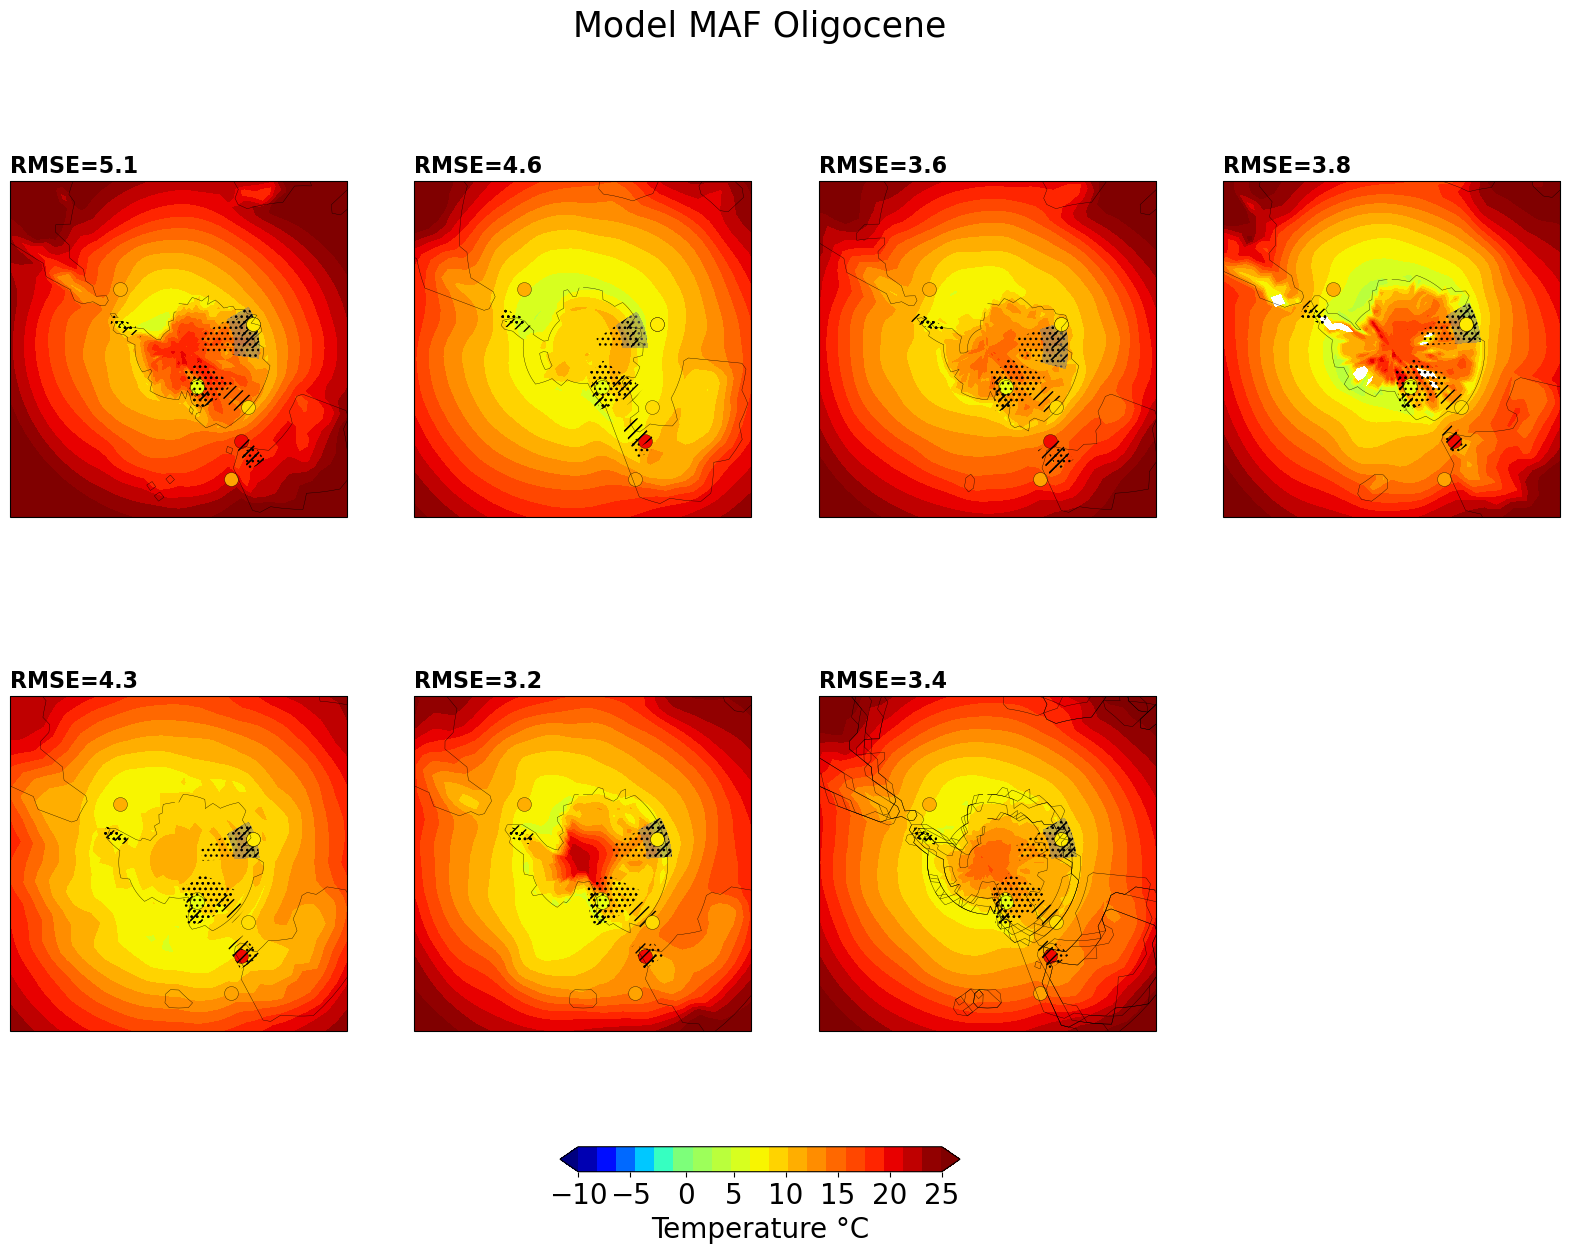

In [74]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=25)

for j in range(0,len(SATmodel_Oligo)):
    var = SATmodel_Oligo[j,:,:]

# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=SATmodel_Oligo.longitude)

# Make a filled contour plot
    datlist=list([0,1,2,3,4,5,6,7])
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap='jet',norm=norm,levels=np.linspace(-10,25,20),extend='both')
# Add coastlines
    if j==6:
        for k in range(0,6):
            coast_all=landmask_2x[k,:,:]*1
            ax.contour(landmask_2x.longitude,landmask_2x.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    else:
        coast=landmask_2x[j,:,:]*1
        ax.contour(landmask_2x.longitude,landmask_2x.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_Oligo[j]),fontweight='bold', fontsize=16,loc='left')
    
    for h in (datlist):
        circ,lon= add_cyclic_point(circles_Oligo[h,j],coord=SATmodel_Oligo[j].longitude)
        circ_E,lon= add_cyclic_point(circles_Eocene[h,j],coord=SATmodel_EO[j].longitude)
        cb=ax.contourf(lon,var.latitude,circ_E ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none',hatches=['...'])
        ca=ax.contourf(lon,var.latitude,circ ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none',hatches=['///'])
        if h==0:
            cb=ax.contourf(lon,var.latitude,circ_E ,transform = ccrs.PlateCarree(), levels=[0,1],colors='grey',alpha=0.5,hatches=[None])
#Add in proxy datapoints and new point locations
        cd=ax.scatter(Oligo_proxy_SAT['Paleolongitude'][h],Oligo_proxy_SAT['Paleolatitude'][h],c=Oligo_proxy_SAT['Oligo SAT'][h],s=100,cmap='jet',norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
      
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5,10,15,20,25,30,35,40])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model MAF Oligocene',fontsize=25)
plt.savefig('SAT_CO2OligoceneMAF_proxymodel.pdf')

EOT difference

In [75]:
#create separate datafiles for each model for the proxy input to adjust paleocoordinates and model averaging
proxy_SAT=EOT_proxy_SAT.dropna().reset_index(drop=True)
proxy_SAT_0=proxy_SAT[:]
proxy_SAT_1=proxy_SAT[:]
proxy_SAT_2=proxy_SAT[:]
proxy_SAT_3=proxy_SAT[:]
proxy_SAT_4=proxy_SAT[:]
proxy_SAT_5=proxy_SAT[:]
proxy_SAT_6=proxy_SAT[:]

In [76]:
#1st model
proxy_SAT_0['New paleolat']=proxy_SAT_0['Paleolatitude']
proxy_SAT_0['New paleolon']=proxy_SAT_0['Paleolongitude']

latchange=[-7,-7,0,5,-10,-3]
lonchange=[5,5,-10,0,-18,-12]
for i in range(0,6):
        proxy_SAT_0['New paleolat'][i]=proxy_SAT_0['Paleolatitude'][i]+latchange[i]
        proxy_SAT_0['New paleolon'][i]=proxy_SAT_0['Paleolongitude'][i]+lonchange[i]

#2nd model
proxy_SAT_1['New paleolat']=proxy_SAT_1['Paleolatitude']
proxy_SAT_1['New paleolon']=proxy_SAT_1['Paleolongitude']

latchange=[-12,-12,0,-3,-5,-11]
lonchange=[0,0,0,2.5,-18,-10]
for i in range(0,6):
        proxy_SAT_1['New paleolat'][i]=proxy_SAT_1['Paleolatitude'][i]+latchange[i]
        proxy_SAT_1['New paleolon'][i]=proxy_SAT_1['Paleolongitude'][i]+lonchange[i]

#3rd model        
proxy_SAT_2['New paleolat']=proxy_SAT_2['Paleolatitude']
proxy_SAT_2['New paleolon']=proxy_SAT_2['Paleolongitude']
latchange=[-8,-8,0,5,-5,-3]
lonchange=[15,15,0,2,-15,-10]
for i in range(0,6):
        proxy_SAT_2['New paleolat'][i]=proxy_SAT_2['Paleolatitude'][i]+latchange[i]
        proxy_SAT_2['New paleolon'][i]=proxy_SAT_2['Paleolongitude'][i]+lonchange[i]

#4th model        
proxy_SAT_3['New paleolat']=proxy_SAT_3['Paleolatitude']
proxy_SAT_3['New paleolon']=proxy_SAT_3['Paleolongitude']        
latchange=[-5,-5,0,0,-2,-8]
lonchange=[0,0,0,0,-13,-12]
for i in range(0,6):
        proxy_SAT_3['New paleolat'][i]=proxy_SAT_3['Paleolatitude'][i]+latchange[i]
        proxy_SAT_3['New paleolon'][i]=proxy_SAT_3['Paleolongitude'][i]+lonchange[i]
        
#5th model        
proxy_SAT_4['New paleolat']=proxy_SAT_4['Paleolatitude']
proxy_SAT_4['New paleolon']=proxy_SAT_4['Paleolongitude']        
latchange=[-7,-7,0,0,-5,-8]
lonchange=[0,0,0,-2,-15,-14]
for i in range(0,6):
        proxy_SAT_4['New paleolat'][i]=proxy_SAT_4['Paleolatitude'][i]+latchange[i]
        proxy_SAT_4['New paleolon'][i]=proxy_SAT_4['Paleolongitude'][i]+lonchange[i]
        
#6th model        
proxy_SAT_5['New paleolat']=proxy_SAT_5['Paleolatitude']
proxy_SAT_5['New paleolon']=proxy_SAT_5['Paleolongitude']        
latchange=[-6,-6,0,0,-5,-8]
lonchange=[0,0,0,0,-13,-12]
for i in range(0,6):
        proxy_SAT_5['New paleolat'][i]=proxy_SAT_5['Paleolatitude'][i]+latchange[i]
        proxy_SAT_5['New paleolon'][i]=proxy_SAT_5['Paleolongitude'][i]+lonchange[i]
        
#7th model ensemble average       
proxy_SAT_6['New paleolat']=proxy_SAT_6['Paleolatitude']
proxy_SAT_6['New paleolon']=proxy_SAT_6['Paleolongitude']        
latchange=[-5,-5,0,0,-5,-8]
lonchange=[0,0,0,0,-16,-12]
for i in range(0,6):
        proxy_SAT_6['New paleolat'][i]=proxy_SAT_6['Paleolatitude'][i]+latchange[i]
        proxy_SAT_6['New paleolon'][i]=proxy_SAT_6['Paleolongitude'][i]+lonchange[i]

/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [77]:
proxy_SAT_0=proxy_SAT_0.to_xarray()
proxy_SAT_1=proxy_SAT_1.to_xarray()
proxy_SAT_2=proxy_SAT_2.to_xarray()
proxy_SAT_3=proxy_SAT_3.to_xarray()
proxy_SAT_4=proxy_SAT_4.to_xarray()
proxy_SAT_5=proxy_SAT_5.to_xarray()
proxy_SAT_6=proxy_SAT_6.to_xarray()

SAT_proxy=proxy_SAT_0.expand_dims(dim='nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_1],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_2],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_3],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_4],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_5],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_6],'nmodels')


In [78]:
proxy_SAT['Paleolongitude'][0]=69
proxy_SAT['Paleolongitude'][2]=150

In [79]:
#drop 3 and 5
Oligo_0=Oligo_weighted_SAT.drop([5],dim='nproxies')
Oligoco2_weightadjust=Oligo_0.drop([3],dim='nproxies')

In [80]:
EOTco2_diffadjust=Oligoco2_weightadjust-EOco2_weightadjust
prox=proxy_SAT['EOT diff']
datlist=list([0,1,2,3,4,5])
errors=np.empty((6,7))
rms_diffSAT=np.empty((7))
prox=np.empty((6))
for i in range(0, len(datlist)):
    prox[i] = proxy_SAT['EOT diff'][datlist][i]
    
for ex in range(0,len(diff_modelconc_SAT)):
    errors[:,ex]=(EOTco2_diffadjust[:,ex]-prox[:])
    rms_diffSAT[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(datlist)).round(decimals=1)
rms_diffSAT

array([2.4, 2.4, 2.6, 1.8, 1.8, 1.9, 2.1])

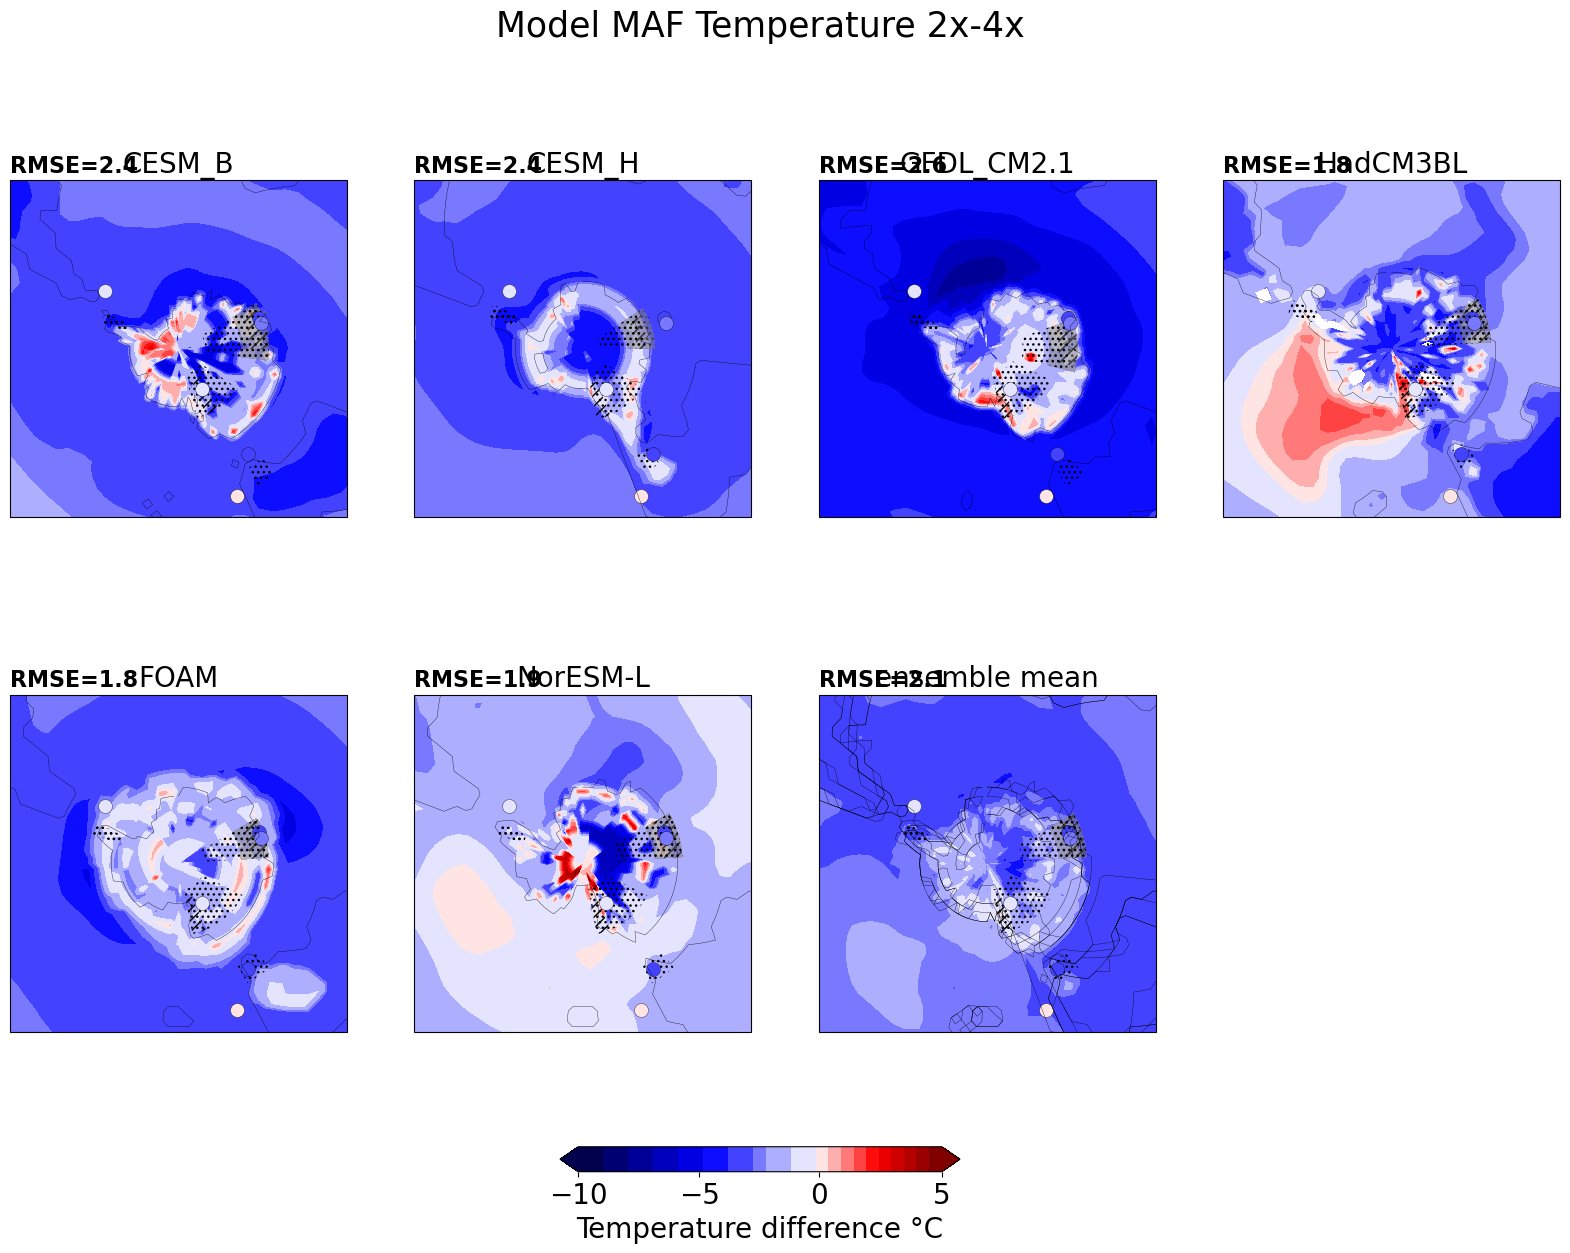

In [81]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=5)

for j in range(0,len(diff_modelconc_SAT)):
    var = diff_modelconc_SAT[j][lats,lons]

# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=diff_modelconc_SAT[j].longitude)

# Make a filled contour plot
    datlist=[0,1,2,3,4,5]
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,5,30),extend='both')
    if j==6:
        for k in range(0,6):
            coast_all=landmask_4x[k,:,:]*1
            ax.contour(landmask_4x.longitude,landmask_4x.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title("ensemble mean", fontsize=20)
    else:
        coast=landmask_4x[j,:,:]*1
        ax.contour(landmask_4x.longitude,landmask_4x.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        ax.set_title(model_high[j], fontsize=20)
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_diffSAT[j]),fontweight='bold', fontsize=16,loc='left')
    #add hatching to distinguish the Eocene and Oligocene source areas
    datlist_Oligo=list([0,1,2,3,4,5])
    for i in (datlist_Oligo):
        circ,lon= add_cyclic_point(circles_Oligo[i,j],coord=SATmodel_Oligo[j].longitude)
        if i==3 or i==4 or i==5:
            continue
        ca=ax.contourf(lon,var.latitude,circ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none',hatches=['///'])
    for h in (datlist):   
        circ_E,lon= add_cyclic_point(circles_Eocene[h,j],coord=SATmodel_EO[j].longitude)
        cb=ax.contourf(lon,var.latitude,circ_E ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none',hatches=['...'])
        if h==0:
            cb=ax.contourf(lon,var.latitude,circ_E ,transform = ccrs.PlateCarree(), levels=[0,1],colors='grey',alpha=0.5,hatches=[None])
#Add in proxy datapoints and new point locations
        cd=ax.scatter(proxy_SAT['Paleolongitude'][h],proxy_SAT['Paleolatitude'][h],c=proxy_SAT['EOT diff'][h],s=100,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())

colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model MAF Temperature 2x-4x',fontsize=25)
plt.savefig('SAT_tempdiffMAF_proxymodel.pdf')

MAF proxy and MAF model CO2

In [82]:
nxx=101
testarray=np.linspace(0,2,nxx)

In [83]:
#This code is for the model area averaging which is stored in the mean_SAT
array=np.empty((101,6,7))
vect=xr.DataArray(array,dims=['nxx','nproxies','nmodels'])
for j in range (0,len(testarray)):
    for i in range (0,len(EOTco2_diffadjust)):
        vect[j,i,:]=testarray[j]*EOTco2_diffadjust[i,:]

In [84]:
#nearest point
errs_1d=np.empty((101,7))
for i in range(0,len(vect.nxx)):
    for j in range(0,len(vect.nmodels)):
        errs_1d[i,j]=SKILL(vect[i,:,j],proxy_SAT['EOT diff'],6)
        
inval_1d=np.min(errs_1d,axis=0)
ind_1d=np.argmin(errs_1d,axis=0)

In [85]:
CO2drop=560*2**testarray[ind_1d]
percentdecrease=(CO2drop-560)/CO2drop*100
print(CO2drop,percentdecrease)

Co2change=CO2drop-560
print(Co2change)

[770.30341816 759.69842337 738.92443003 837.11557924 872.66432922
 814.2246097  803.01493889] [27.30137413 26.28653914 24.21417167 33.10362226 35.82870512 31.22290909
 30.26281668]
[210.30341816 199.69842337 178.92443003 277.11557924 312.66432922
 254.2246097  243.01493889]


RMSE and plotting best scaling fir for each model

In [86]:
diff_modelscale_SAT=diff_modelconc_SAT.copy(deep=True)
for i in range (0,len(ind_1d)):
        diff_modelscale_SAT[i,:,:]=testarray[ind_1d[i]]*diff_modelconc_SAT[i,:,:]

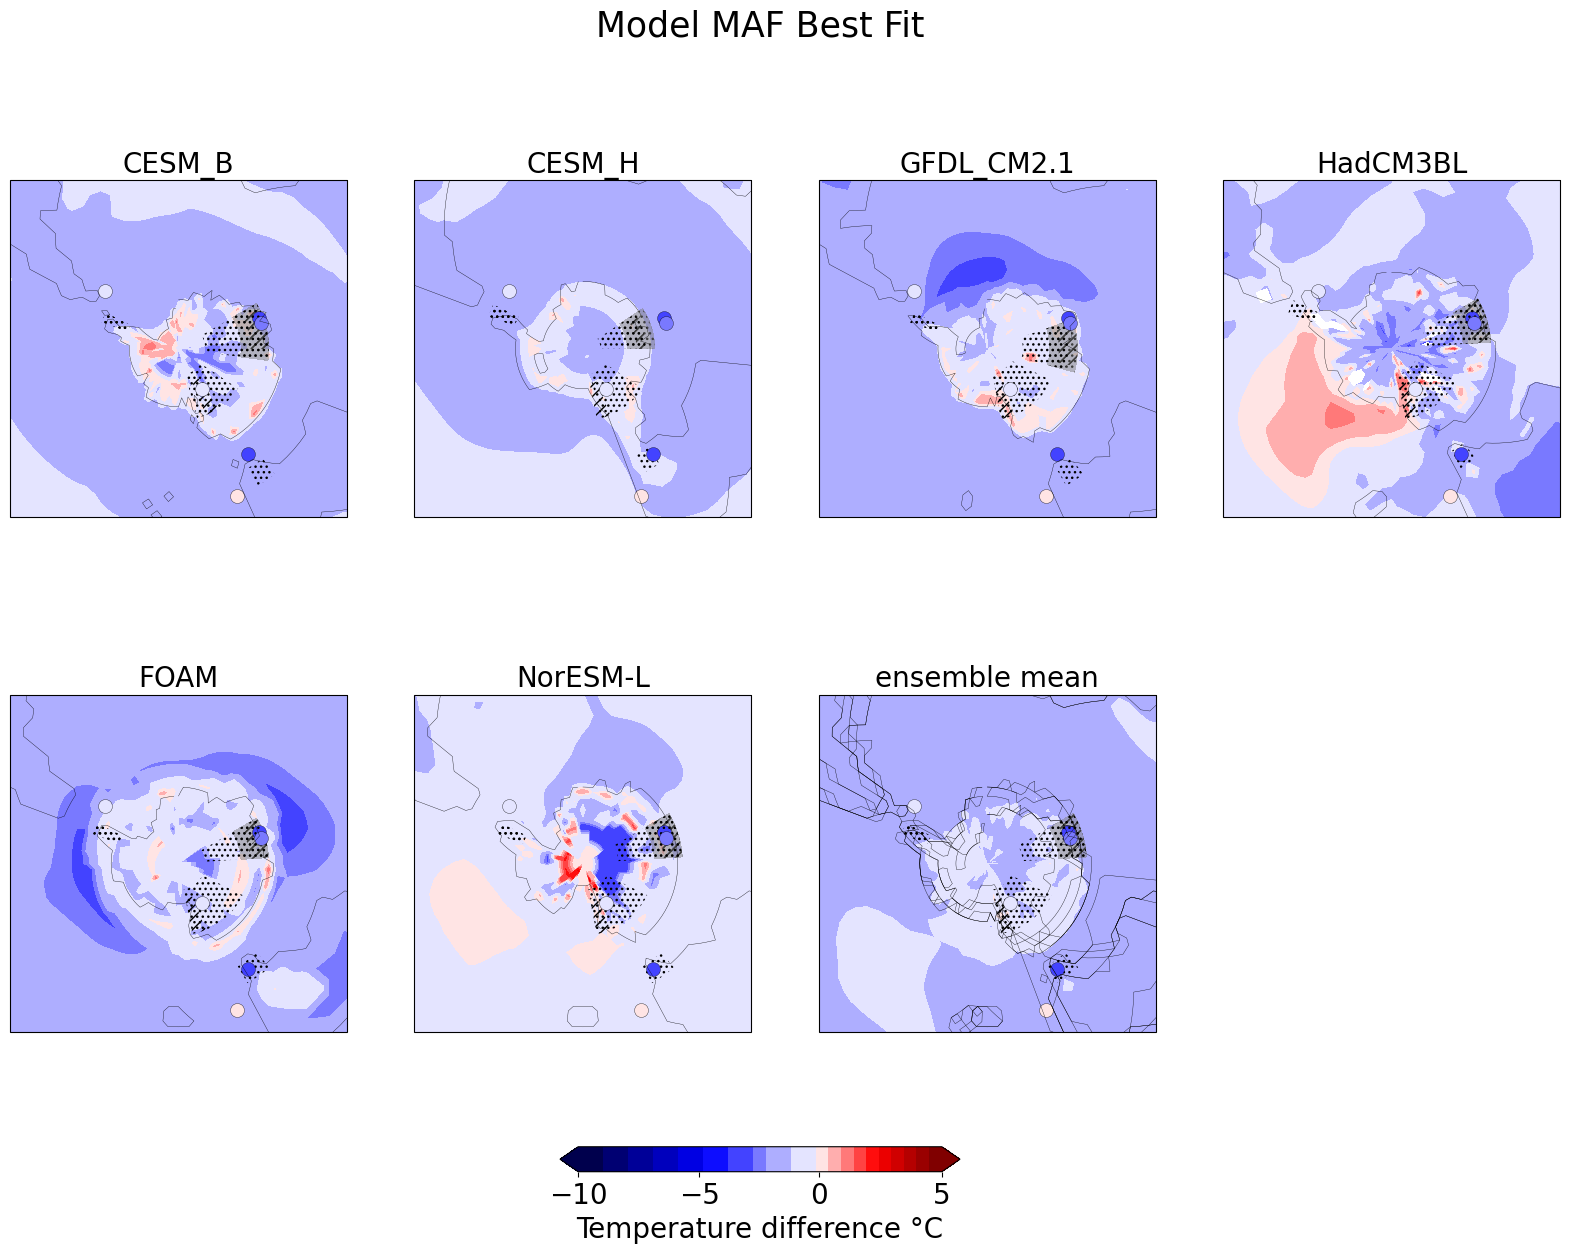

In [87]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=5)

for j in range(0,len(diff_modelscale_SAT)):
    var = diff_modelscale_SAT[j][lats,lons]
    
# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=diff_modelscale_SAT.longitude)

# Make a filled contour plot
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,5,30),extend='both')
    coast=landmask[j,:,:]*1
    if j==6:
        for k in range(0,6):
            coast_all=landmask[k,:,:]*1
            ax.contour(landmask.longitude,landmask.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title("ensemble mean", fontsize=20)
    else:
        ax.contour(landmask.longitude,landmask.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        ax.set_title(model_SAT[j], fontsize=20)
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    datlist=[0,1,2,3,4,5]
#add hatching to distinguish the Eocene and Oligocene source areas
    datlist_Oligo=list([0,1,2,3,4,5])
    for i in (datlist_Oligo):
        circ,lon= add_cyclic_point(circles_Oligo[i,j],coord=SATmodel_Oligo[j].longitude)
        if i==3 or i==4 or i==5:
            continue
        ca=ax.contourf(lon,var.latitude,circ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none',hatches=['///'])
    for h in (datlist):   
        circ_E,lon= add_cyclic_point(circles_Eocene[h,j],coord=SATmodel_EO[j].longitude)
        cb=ax.contourf(lon,var.latitude,circ_E ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none',hatches=['...'])
        if h==0:
            cb=ax.contourf(lon,var.latitude,circ_E ,transform = ccrs.PlateCarree(), levels=[0,1],colors='grey',alpha=0.5,hatches=[None])
#Add in proxy datapoints and new point locations
        cd=ax.scatter(proxy_SAT['Paleolongitude'][h],proxy_SAT['Paleolatitude'][h],c=proxy_SAT['EOT diff'][h],s=100,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
      
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model MAF Best Fit',fontsize=25)
plt.savefig('SAT_CO2bestfitMAF_proxymodel.pdf')